In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    recall_score,
)

import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from eli5.sklearn import PermutationImportance
import shap

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-14 14:51:17.931767: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-14 14:51:17.971938: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 14:51:18.843679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

In [2]:
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

In [3]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 데이터 불러오기
train = pd.read_csv('./data/train_0814_variable.csv')
test = pd.read_csv('./data/test_0814_variable.csv')

In [5]:
train.columns

Index(['target', 'inconsistant', 'distance_diff_dam_fill1_stage1',
       'distance_diff_dam_fill2_stage1', 'distance_diff_fill1_fill2_stage1',
       'distance_diff_dam_fill1_stage2', 'distance_diff_dam_fill2_stage2',
       'distance_diff_fill1_fill2_stage2', 'distance_diff_dam_fill1_stage3',
       'distance_diff_dam_fill2_stage3', 'distance_diff_fill1_fill2_stage3',
       'cure_time_dam', 'cure_time_fill2', 'press21_autoclave', 'thon_time',
       'discharged_dist_stage1_dam', 'discharged_dist_stage2_dam',
       'discharged_dist_stage3_dam', 'equip', 'dam_time', 'fill1_time',
       'fill2_time', 'autoclave_time', 'pallet', 'qty', 'receip',
       'chamber_temp', 'model_suffix'],
      dtype='object')

In [6]:
train['pallet'] = train['pallet'].astype('int64').astype(str)
test['pallet'] = test['pallet'].astype('int64').astype(str)

In [7]:
# 각 영역별 
dam = ['target', 'inconsistant', 'distance_diff_dam_fill1_stage1',
       'distance_diff_dam_fill2_stage1', 'distance_diff_fill1_fill2_stage1',
       'cure_time_dam', 'cure_time_fill2', 'thon_time',
       'discharged_dist_stage1_dam',
       'equip', 'pallet', 'receip',
       'model_suffix']
fill1 = [
        'target', 'inconsistant',
       'distance_diff_dam_fill1_stage2', 'distance_diff_dam_fill2_stage2',
       'distance_diff_fill1_fill2_stage2', 
       'cure_time_dam', 'cure_time_fill2', 'thon_time',
       'discharged_dist_stage2_dam',
       'equip', 'pallet', 'receip',
       'model_suffix'
        ]
fill2 = [
        'target', 'inconsistant', 'distance_diff_dam_fill1_stage3',
       'distance_diff_dam_fill2_stage3', 'distance_diff_fill1_fill2_stage3',
       'cure_time_dam', 'cure_time_fill2', 'thon_time',
       'discharged_dist_stage3_dam',
       'equip', 'pallet', 'receip',
       'model_suffix'
]
autoclave = [
        'target', 'inconsistant', 
       'press21_autoclave',
        'equip', 'dam_time', 'fill1_time',
       'fill2_time', 'autoclave_time', 'pallet', 'receip',
       'chamber_temp', 'model_suffix'
            ]

df_dam = train[dam]
df_fill1 = train[fill1]
df_fill2 = train[fill2]
df_autoclave = train[autoclave]

# Stage1

In [8]:
X_dam = df_dam.drop(columns=['target'])
y_dam = df_dam['target']

cat_features_indices_dam = ['pallet', 'receip', 'equip', 'thon_time', 'model_suffix']

X_train, X_valid, y_train, y_valid = train_test_split(X_dam, y_dam, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 1, 20),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-14 14:51:20,627] A new study created in memory with name: no-name-924547dc-20be-402a-8690-14f8b8a05f4d
[I 2024-08-14 14:51:22,955] Trial 0 finished with value: 0.5318412067124145 and parameters: {'iterations': 321, 'depth': 6, 'learning_rate': 0.2669658899629951, 'l2_leaf_reg': 6.5721250835784035, 'border_count': 210, 'random_strength': 5.289594866322667, 'bagging_temperature': 0.22020099494158918, 'od_type': 'Iter', 'od_wait': 19, 'boosting_type': 'Ordered', 'scale_pos_weight': 5}. Best is trial 0 with value: 0.5318412067124145.
[I 2024-08-14 14:51:26,471] Trial 1 finished with value: 0.5338519219572858 and parameters: {'iterations': 268, 'depth': 4, 'learning_rate': 0.10192695924337776, 'l2_leaf_reg': 7.742334589262991, 'border_count': 115, 'random_strength': 9.47020573368641, 'bagging_temperature': 0.773371381808747, 'od_type': 'Iter', 'od_wait': 35, 'boosting_type': 'Ordered', 'scale_pos_weight': 5}. Best is trial 1 with value: 0.5338519219572858.
[I 2024-08-14 14:51:36,

[I 2024-08-14 14:53:01,081] Trial 19 finished with value: 0.47548803423058195 and parameters: {'iterations': 612, 'depth': 5, 'learning_rate': 0.005472885633191209, 'l2_leaf_reg': 7.504473384788602, 'border_count': 67, 'random_strength': 3.1949948811083297, 'bagging_temperature': 0.5005696201533182, 'od_type': 'Iter', 'od_wait': 16, 'boosting_type': 'Ordered', 'scale_pos_weight': 17}. Best is trial 16 with value: 0.5478965686830856.
[I 2024-08-14 14:53:03,510] Trial 20 finished with value: 0.5379884457800178 and parameters: {'iterations': 457, 'depth': 7, 'learning_rate': 0.43586541301197, 'l2_leaf_reg': 6.167877106304089, 'border_count': 65, 'random_strength': 1.0046599883003853, 'bagging_temperature': 0.11382145188369537, 'od_type': 'Iter', 'od_wait': 21, 'boosting_type': 'Ordered', 'scale_pos_weight': 3}. Best is trial 16 with value: 0.5478965686830856.
[I 2024-08-14 14:53:06,098] Trial 21 finished with value: 0.5359902158932616 and parameters: {'iterations': 456, 'depth': 7, 'learn

[I 2024-08-14 14:53:46,801] Trial 38 finished with value: 0.5444868402311861 and parameters: {'iterations': 329, 'depth': 5, 'learning_rate': 0.05959900484977923, 'l2_leaf_reg': 2.6995294948304194, 'border_count': 220, 'random_strength': 8.289835704331624, 'bagging_temperature': 0.7051587357764012, 'od_type': 'IncToDec', 'od_wait': 24, 'boosting_type': 'Plain', 'scale_pos_weight': 8}. Best is trial 31 with value: 0.5495712788932368.
[I 2024-08-14 14:53:49,837] Trial 39 finished with value: 0.5047666665002435 and parameters: {'iterations': 306, 'depth': 4, 'learning_rate': 0.008763491597865993, 'l2_leaf_reg': 1.0273537653457212, 'border_count': 193, 'random_strength': 5.073429172913939, 'bagging_temperature': 0.921304236672165, 'od_type': 'IncToDec', 'od_wait': 29, 'boosting_type': 'Plain', 'scale_pos_weight': 13}. Best is trial 31 with value: 0.5495712788932368.
[I 2024-08-14 14:53:50,407] Trial 40 finished with value: 0.5266214392582513 and parameters: {'iterations': 113, 'depth': 6, 

Best trial:
  Value: 0.554941503772568
  Params: 
    iterations: 148
    depth: 4
    learning_rate: 0.6840887822358451
    l2_leaf_reg: 3.0077469617127877
    border_count: 180
    random_strength: 4.5266197141515825
    bagging_temperature: 0.9310458947831778
    od_type: IncToDec
    od_wait: 16
    boosting_type: Plain
    scale_pos_weight: 6


In [9]:
study.best_trial.params

{'iterations': 148,
 'depth': 4,
 'learning_rate': 0.6840887822358451,
 'l2_leaf_reg': 3.0077469617127877,
 'border_count': 180,
 'random_strength': 4.5266197141515825,
 'bagging_temperature': 0.9310458947831778,
 'od_type': 'IncToDec',
 'od_wait': 16,
 'boosting_type': 'Plain',
 'scale_pos_weight': 6}

In [10]:
# 최적의 하이퍼파라미터로 모델 재학습
dam_best_params = study.best_trial.params
dam_best_model = CatBoostClassifier(**dam_best_params)
dam_best_model.fit(X_train, y_train, cat_features=cat_features_indices)

0:	learn: 0.5804374	total: 4.19ms	remaining: 616ms
1:	learn: 0.5604299	total: 8.58ms	remaining: 626ms
2:	learn: 0.5555038	total: 12.4ms	remaining: 598ms
3:	learn: 0.5519832	total: 15.8ms	remaining: 568ms
4:	learn: 0.5512851	total: 19.3ms	remaining: 553ms
5:	learn: 0.5503963	total: 22.8ms	remaining: 540ms
6:	learn: 0.5497068	total: 26.1ms	remaining: 525ms
7:	learn: 0.5494780	total: 28.5ms	remaining: 498ms
8:	learn: 0.5488121	total: 31.7ms	remaining: 489ms
9:	learn: 0.5487559	total: 34.8ms	remaining: 480ms
10:	learn: 0.5487321	total: 37.2ms	remaining: 463ms
11:	learn: 0.5483378	total: 40.7ms	remaining: 461ms
12:	learn: 0.5483366	total: 43.6ms	remaining: 453ms
13:	learn: 0.5483333	total: 46.9ms	remaining: 448ms
14:	learn: 0.5477520	total: 50.2ms	remaining: 446ms
15:	learn: 0.5469539	total: 53.4ms	remaining: 441ms
16:	learn: 0.5457119	total: 56.8ms	remaining: 438ms
17:	learn: 0.5453592	total: 60.2ms	remaining: 435ms
18:	learn: 0.5440343	total: 63.6ms	remaining: 432ms
19:	learn: 0.5426018	t

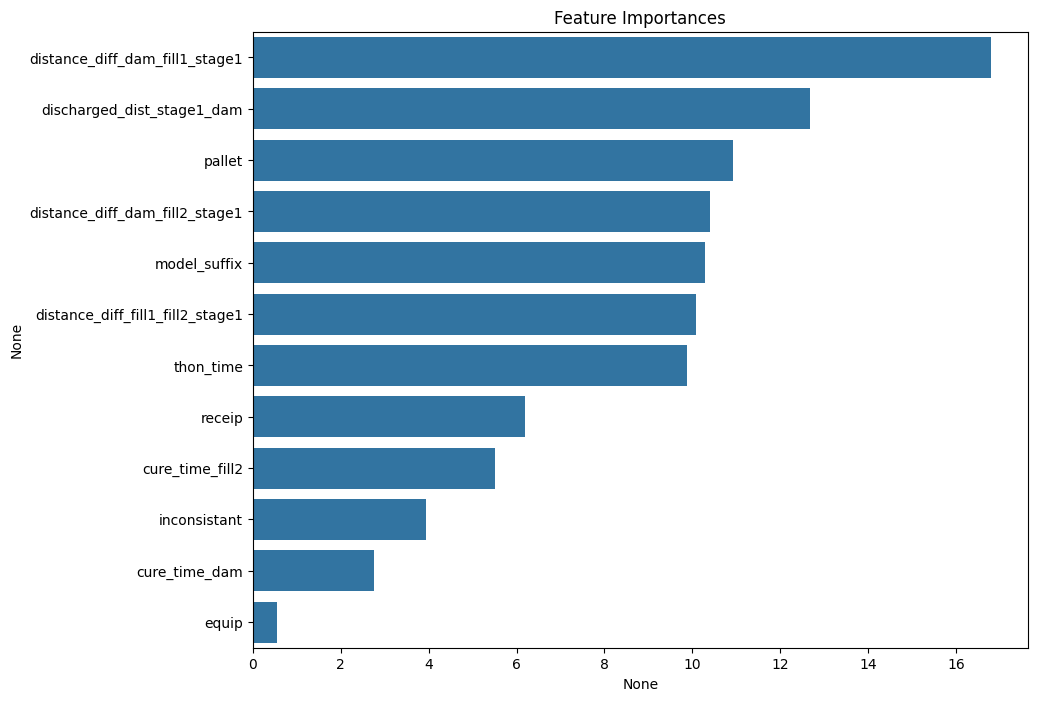

In [11]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(dam_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [12]:
pred = dam_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  50  408]
 [ 120 7524]]

정확도: 0.9348
정밀도: 0.2941
재현율: 0.1092
F1: 0.1592


# Stage2

In [13]:
X_fill1 = df_fill1.drop(columns=['target'])
y_fill1 = df_fill1['target']

cat_features_indices_fill1 = ['pallet', 'receip', 'equip', 'thon_time', 'model_suffix']

X_train, X_valid, y_train, y_valid = train_test_split(X_fill1, y_fill1, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 1, 20),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-14 14:54:01,244] A new study created in memory with name: no-name-669180ef-9695-4ea6-9c7d-d1949c02c545
[I 2024-08-14 14:54:16,079] Trial 0 finished with value: 0.22267962049036516 and parameters: {'iterations': 543, 'depth': 9, 'learning_rate': 0.002648912929464692, 'l2_leaf_reg': 9.512125383283115, 'border_count': 135, 'random_strength': 5.975088708646314, 'bagging_temperature': 0.6711127823828213, 'od_type': 'Iter', 'od_wait': 47, 'boosting_type': 'Ordered', 'scale_pos_weight': 20}. Best is trial 0 with value: 0.22267962049036516.
[I 2024-08-14 14:54:18,276] Trial 1 finished with value: 0.5227195628548503 and parameters: {'iterations': 499, 'depth': 6, 'learning_rate': 0.055270485831245296, 'l2_leaf_reg': 3.729528520894983, 'border_count': 247, 'random_strength': 5.735074576396525, 'bagging_temperature': 0.5056897404784558, 'od_type': 'Iter', 'od_wait': 37, 'boosting_type': 'Plain', 'scale_pos_weight': 11}. Best is trial 1 with value: 0.5227195628548503.
[I 2024-08-14 14:5

[I 2024-08-14 14:56:14,043] Trial 19 finished with value: 0.5319691766302044 and parameters: {'iterations': 858, 'depth': 7, 'learning_rate': 0.004385532326879666, 'l2_leaf_reg': 8.443698521932395, 'border_count': 103, 'random_strength': 3.2479677415984876, 'bagging_temperature': 0.6119699550388721, 'od_type': 'IncToDec', 'od_wait': 13, 'boosting_type': 'Plain', 'scale_pos_weight': 7}. Best is trial 8 with value: 0.5557492003464756.
[I 2024-08-14 14:56:15,203] Trial 20 finished with value: 0.5351302542228831 and parameters: {'iterations': 650, 'depth': 5, 'learning_rate': 0.43469569989573037, 'l2_leaf_reg': 4.390581122768777, 'border_count': 60, 'random_strength': 1.3188676690041277, 'bagging_temperature': 0.18936587515446346, 'od_type': 'Iter', 'od_wait': 29, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 8 with value: 0.5557492003464756.
[I 2024-08-14 14:56:24,704] Trial 21 finished with value: 0.5482778789329604 and parameters: {'iterations': 803, 'depth': 9, 'lear

[I 2024-08-14 14:58:48,522] Trial 38 finished with value: 0.544191506818761 and parameters: {'iterations': 252, 'depth': 9, 'learning_rate': 0.27876543090972405, 'l2_leaf_reg': 3.0421207425133057, 'border_count': 243, 'random_strength': 9.702916540961436, 'bagging_temperature': 0.6661419187964689, 'od_type': 'IncToDec', 'od_wait': 31, 'boosting_type': 'Plain', 'scale_pos_weight': 7}. Best is trial 8 with value: 0.5557492003464756.
[I 2024-08-14 14:58:52,134] Trial 39 finished with value: 0.43184532288246347 and parameters: {'iterations': 693, 'depth': 7, 'learning_rate': 0.061098101113335114, 'l2_leaf_reg': 5.0392032641565665, 'border_count': 47, 'random_strength': 3.4986125397999612, 'bagging_temperature': 0.349944979872282, 'od_type': 'Iter', 'od_wait': 27, 'boosting_type': 'Plain', 'scale_pos_weight': 20}. Best is trial 8 with value: 0.5557492003464756.
[I 2024-08-14 14:58:53,244] Trial 40 finished with value: 0.5319691766302044 and parameters: {'iterations': 103, 'depth': 8, 'learn

Best trial:
  Value: 0.5557492003464756
  Params: 
    iterations: 1000
    depth: 10
    learning_rate: 0.29935726362936255
    l2_leaf_reg: 9.620148983196216
    border_count: 42
    random_strength: 3.5702031426950382
    bagging_temperature: 0.539821078880518
    od_type: Iter
    od_wait: 17
    boosting_type: Plain
    scale_pos_weight: 8


In [14]:
study.best_trial.params

{'iterations': 1000,
 'depth': 10,
 'learning_rate': 0.29935726362936255,
 'l2_leaf_reg': 9.620148983196216,
 'border_count': 42,
 'random_strength': 3.5702031426950382,
 'bagging_temperature': 0.539821078880518,
 'od_type': 'Iter',
 'od_wait': 17,
 'boosting_type': 'Plain',
 'scale_pos_weight': 8}

In [15]:
# 최적의 하이퍼파라미터로 모델 재학습
fill1_best_params = study.best_trial.params
fill1_best_model = CatBoostClassifier(**fill1_best_params)
fill1_best_model.fit(X_train, y_train, cat_features=cat_features_indices)

0:	learn: 0.6475881	total: 12ms	remaining: 12s
1:	learn: 0.6327114	total: 19.8ms	remaining: 9.86s
2:	learn: 0.6144919	total: 51.2ms	remaining: 17s
3:	learn: 0.6074620	total: 69.5ms	remaining: 17.3s
4:	learn: 0.6038979	total: 84.8ms	remaining: 16.9s
5:	learn: 0.6008077	total: 110ms	remaining: 18.3s
6:	learn: 0.5987144	total: 126ms	remaining: 17.9s
7:	learn: 0.5971146	total: 140ms	remaining: 17.4s
8:	learn: 0.5970246	total: 145ms	remaining: 16s
9:	learn: 0.5969804	total: 150ms	remaining: 14.9s
10:	learn: 0.5965823	total: 164ms	remaining: 14.8s
11:	learn: 0.5947431	total: 196ms	remaining: 16.2s
12:	learn: 0.5947382	total: 202ms	remaining: 15.3s
13:	learn: 0.5929981	total: 228ms	remaining: 16s
14:	learn: 0.5928766	total: 239ms	remaining: 15.7s
15:	learn: 0.5923653	total: 251ms	remaining: 15.5s
16:	learn: 0.5902299	total: 284ms	remaining: 16.4s
17:	learn: 0.5900024	total: 295ms	remaining: 16.1s
18:	learn: 0.5900023	total: 301ms	remaining: 15.5s
19:	learn: 0.5900023	total: 307ms	remaining: 1

163:	learn: 0.4340473	total: 4.43s	remaining: 22.6s
164:	learn: 0.4334952	total: 4.46s	remaining: 22.6s
165:	learn: 0.4328192	total: 4.5s	remaining: 22.6s
166:	learn: 0.4323724	total: 4.53s	remaining: 22.6s
167:	learn: 0.4307433	total: 4.57s	remaining: 22.6s
168:	learn: 0.4305875	total: 4.6s	remaining: 22.6s
169:	learn: 0.4294720	total: 4.64s	remaining: 22.6s
170:	learn: 0.4294141	total: 4.67s	remaining: 22.6s
171:	learn: 0.4294046	total: 4.68s	remaining: 22.5s
172:	learn: 0.4286942	total: 4.72s	remaining: 22.6s
173:	learn: 0.4281992	total: 4.75s	remaining: 22.5s
174:	learn: 0.4281712	total: 4.78s	remaining: 22.5s
175:	learn: 0.4281499	total: 4.81s	remaining: 22.5s
176:	learn: 0.4270949	total: 4.84s	remaining: 22.5s
177:	learn: 0.4266511	total: 4.88s	remaining: 22.5s
178:	learn: 0.4257839	total: 4.91s	remaining: 22.5s
179:	learn: 0.4238178	total: 4.95s	remaining: 22.5s
180:	learn: 0.4232902	total: 4.98s	remaining: 22.5s
181:	learn: 0.4220706	total: 5.01s	remaining: 22.5s
182:	learn: 0.

322:	learn: 0.3498192	total: 9.62s	remaining: 20.2s
323:	learn: 0.3487027	total: 9.65s	remaining: 20.1s
324:	learn: 0.3486919	total: 9.68s	remaining: 20.1s
325:	learn: 0.3473141	total: 9.71s	remaining: 20.1s
326:	learn: 0.3471675	total: 9.75s	remaining: 20.1s
327:	learn: 0.3470537	total: 9.77s	remaining: 20s
328:	learn: 0.3463787	total: 9.81s	remaining: 20s
329:	learn: 0.3458590	total: 9.84s	remaining: 20s
330:	learn: 0.3458469	total: 9.87s	remaining: 20s
331:	learn: 0.3452953	total: 9.91s	remaining: 19.9s
332:	learn: 0.3448673	total: 9.94s	remaining: 19.9s
333:	learn: 0.3441928	total: 9.98s	remaining: 19.9s
334:	learn: 0.3440696	total: 10s	remaining: 19.9s
335:	learn: 0.3438700	total: 10s	remaining: 19.8s
336:	learn: 0.3435276	total: 10.1s	remaining: 19.8s
337:	learn: 0.3433368	total: 10.1s	remaining: 19.8s
338:	learn: 0.3431191	total: 10.1s	remaining: 19.8s
339:	learn: 0.3431044	total: 10.2s	remaining: 19.7s
340:	learn: 0.3430647	total: 10.2s	remaining: 19.7s
341:	learn: 0.3430419	to

481:	learn: 0.2918571	total: 14.8s	remaining: 15.9s
482:	learn: 0.2915509	total: 14.9s	remaining: 15.9s
483:	learn: 0.2913300	total: 14.9s	remaining: 15.9s
484:	learn: 0.2911353	total: 14.9s	remaining: 15.9s
485:	learn: 0.2909289	total: 15s	remaining: 15.8s
486:	learn: 0.2901272	total: 15s	remaining: 15.8s
487:	learn: 0.2898712	total: 15s	remaining: 15.8s
488:	learn: 0.2894909	total: 15.1s	remaining: 15.8s
489:	learn: 0.2888961	total: 15.1s	remaining: 15.7s
490:	learn: 0.2887586	total: 15.1s	remaining: 15.7s
491:	learn: 0.2883566	total: 15.2s	remaining: 15.7s
492:	learn: 0.2881148	total: 15.2s	remaining: 15.6s
493:	learn: 0.2877517	total: 15.2s	remaining: 15.6s
494:	learn: 0.2872750	total: 15.3s	remaining: 15.6s
495:	learn: 0.2872747	total: 15.3s	remaining: 15.5s
496:	learn: 0.2867491	total: 15.3s	remaining: 15.5s
497:	learn: 0.2867422	total: 15.4s	remaining: 15.5s
498:	learn: 0.2867421	total: 15.4s	remaining: 15.4s
499:	learn: 0.2865348	total: 15.4s	remaining: 15.4s
500:	learn: 0.2865

641:	learn: 0.2430657	total: 20s	remaining: 11.1s
642:	learn: 0.2430556	total: 20s	remaining: 11.1s
643:	learn: 0.2429617	total: 20s	remaining: 11.1s
644:	learn: 0.2428828	total: 20.1s	remaining: 11.1s
645:	learn: 0.2425657	total: 20.1s	remaining: 11s
646:	learn: 0.2424763	total: 20.1s	remaining: 11s
647:	learn: 0.2422746	total: 20.2s	remaining: 11s
648:	learn: 0.2419301	total: 20.2s	remaining: 10.9s
649:	learn: 0.2415814	total: 20.3s	remaining: 10.9s
650:	learn: 0.2412996	total: 20.3s	remaining: 10.9s
651:	learn: 0.2410592	total: 20.3s	remaining: 10.8s
652:	learn: 0.2407215	total: 20.4s	remaining: 10.8s
653:	learn: 0.2404845	total: 20.4s	remaining: 10.8s
654:	learn: 0.2404792	total: 20.4s	remaining: 10.8s
655:	learn: 0.2404789	total: 20.4s	remaining: 10.7s
656:	learn: 0.2399102	total: 20.5s	remaining: 10.7s
657:	learn: 0.2390388	total: 20.5s	remaining: 10.7s
658:	learn: 0.2388601	total: 20.5s	remaining: 10.6s
659:	learn: 0.2387070	total: 20.6s	remaining: 10.6s
660:	learn: 0.2385039	to

803:	learn: 0.2117154	total: 25.3s	remaining: 6.17s
804:	learn: 0.2116988	total: 25.4s	remaining: 6.14s
805:	learn: 0.2115868	total: 25.4s	remaining: 6.11s
806:	learn: 0.2115868	total: 25.4s	remaining: 6.07s
807:	learn: 0.2115100	total: 25.4s	remaining: 6.04s
808:	learn: 0.2112984	total: 25.5s	remaining: 6.01s
809:	learn: 0.2111194	total: 25.5s	remaining: 5.98s
810:	learn: 0.2110922	total: 25.5s	remaining: 5.95s
811:	learn: 0.2105804	total: 25.6s	remaining: 5.92s
812:	learn: 0.2105766	total: 25.6s	remaining: 5.89s
813:	learn: 0.2105636	total: 25.6s	remaining: 5.86s
814:	learn: 0.2105636	total: 25.7s	remaining: 5.82s
815:	learn: 0.2105625	total: 25.7s	remaining: 5.79s
816:	learn: 0.2105608	total: 25.7s	remaining: 5.76s
817:	learn: 0.2104274	total: 25.7s	remaining: 5.73s
818:	learn: 0.2098964	total: 25.8s	remaining: 5.7s
819:	learn: 0.2098760	total: 25.8s	remaining: 5.67s
820:	learn: 0.2096802	total: 25.8s	remaining: 5.63s
821:	learn: 0.2088971	total: 25.9s	remaining: 5.61s
822:	learn: 0

964:	learn: 0.1797458	total: 30.8s	remaining: 1.12s
965:	learn: 0.1797375	total: 30.8s	remaining: 1.08s
966:	learn: 0.1794561	total: 30.8s	remaining: 1.05s
967:	learn: 0.1790516	total: 30.9s	remaining: 1.02s
968:	learn: 0.1789017	total: 30.9s	remaining: 989ms
969:	learn: 0.1789017	total: 30.9s	remaining: 957ms
970:	learn: 0.1784130	total: 31s	remaining: 925ms
971:	learn: 0.1783209	total: 31s	remaining: 893ms
972:	learn: 0.1781996	total: 31s	remaining: 861ms
973:	learn: 0.1780422	total: 31.1s	remaining: 830ms
974:	learn: 0.1780189	total: 31.1s	remaining: 798ms
975:	learn: 0.1777500	total: 31.1s	remaining: 766ms
976:	learn: 0.1775439	total: 31.2s	remaining: 734ms
977:	learn: 0.1774337	total: 31.2s	remaining: 702ms
978:	learn: 0.1773881	total: 31.3s	remaining: 670ms
979:	learn: 0.1770688	total: 31.3s	remaining: 639ms
980:	learn: 0.1767528	total: 31.3s	remaining: 607ms
981:	learn: 0.1766644	total: 31.4s	remaining: 575ms
982:	learn: 0.1765476	total: 31.4s	remaining: 543ms
983:	learn: 0.1765

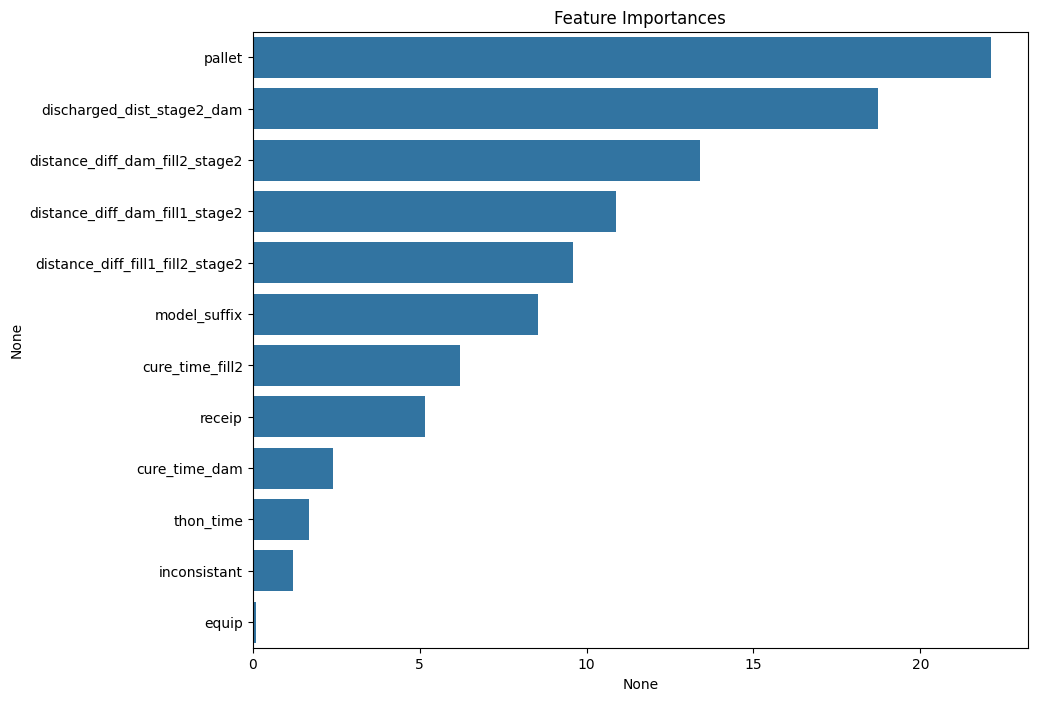

In [16]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(fill1_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [17]:
pred = fill1_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  48  410]
 [ 298 7346]]

정확도: 0.9126
정밀도: 0.1387
재현율: 0.1048
F1: 0.1194


# Stage3

In [18]:
X_fill2 = df_fill2.drop(columns=['target'])
y_fill2 = df_fill2['target']

cat_features_indices_fill2 = ['pallet', 'receip', 'equip', 'thon_time', 'model_suffix']

X_train, X_valid, y_train, y_valid = train_test_split(X_fill2, y_fill2, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 1, 20),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-14 15:00:11,165] A new study created in memory with name: no-name-3c3d27e0-834f-43b1-aa71-6bc812270b77
[I 2024-08-14 15:00:12,877] Trial 0 finished with value: 0.49715895281413836 and parameters: {'iterations': 798, 'depth': 10, 'learning_rate': 0.672392715125803, 'l2_leaf_reg': 3.885759783155183, 'border_count': 152, 'random_strength': 2.535042384434178, 'bagging_temperature': 0.6742800114114106, 'od_type': 'Iter', 'od_wait': 11, 'boosting_type': 'Plain', 'scale_pos_weight': 13}. Best is trial 0 with value: 0.49715895281413836.
[I 2024-08-14 15:00:13,267] Trial 1 finished with value: 0.4578678604141391 and parameters: {'iterations': 192, 'depth': 4, 'learning_rate': 0.6319521464493851, 'l2_leaf_reg': 6.1652596865748075, 'border_count': 92, 'random_strength': 0.35735284974964526, 'bagging_temperature': 0.3038585046530059, 'od_type': 'Iter', 'od_wait': 14, 'boosting_type': 'Plain', 'scale_pos_weight': 17}. Best is trial 0 with value: 0.49715895281413836.
[I 2024-08-14 15:00:1

[I 2024-08-14 15:02:00,338] Trial 19 finished with value: 0.5541241215078121 and parameters: {'iterations': 921, 'depth': 6, 'learning_rate': 0.019912957604370632, 'l2_leaf_reg': 9.153426117279864, 'border_count': 109, 'random_strength': 8.979683789231684, 'bagging_temperature': 0.004165654352978776, 'od_type': 'Iter', 'od_wait': 40, 'boosting_type': 'Plain', 'scale_pos_weight': 9}. Best is trial 19 with value: 0.5541241215078121.
[I 2024-08-14 15:02:11,438] Trial 20 finished with value: 0.5367544750543982 and parameters: {'iterations': 928, 'depth': 6, 'learning_rate': 0.0194118417082343, 'l2_leaf_reg': 8.771615859276139, 'border_count': 112, 'random_strength': 8.767024856679082, 'bagging_temperature': 0.013343607349648658, 'od_type': 'Iter', 'od_wait': 28, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 19 with value: 0.5541241215078121.
[I 2024-08-14 15:02:14,106] Trial 21 finished with value: 0.5409009816979716 and parameters: {'iterations': 694, 'depth': 7, 'learn

[I 2024-08-14 15:04:11,975] Trial 38 finished with value: 0.5359387377601581 and parameters: {'iterations': 1000, 'depth': 7, 'learning_rate': 0.0045535279249367695, 'l2_leaf_reg': 6.583204062554218, 'border_count': 73, 'random_strength': 2.944262275539565, 'bagging_temperature': 0.2748885465044303, 'od_type': 'Iter', 'od_wait': 41, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 35 with value: 0.5573924430330346.
[I 2024-08-14 15:04:17,555] Trial 39 finished with value: 0.5379884457800178 and parameters: {'iterations': 940, 'depth': 9, 'learning_rate': 0.04915324870824542, 'l2_leaf_reg': 4.280388951176461, 'border_count': 120, 'random_strength': 1.6224615010867138, 'bagging_temperature': 0.4760457870401466, 'od_type': 'Iter', 'od_wait': 46, 'boosting_type': 'Plain', 'scale_pos_weight': 3}. Best is trial 35 with value: 0.5573924430330346.
[I 2024-08-14 15:04:28,412] Trial 40 finished with value: 0.5027529904324392 and parameters: {'iterations': 882, 'depth': 8, 'learni

Best trial:
  Value: 0.5573924430330346
  Params: 
    iterations: 949
    depth: 8
    learning_rate: 0.016738973222378713
    l2_leaf_reg: 6.7348568744611805
    border_count: 99
    random_strength: 1.7574228757458115
    bagging_temperature: 0.35510182890151015
    od_type: Iter
    od_wait: 46
    boosting_type: Plain
    scale_pos_weight: 9


In [19]:
study.best_trial.params

{'iterations': 949,
 'depth': 8,
 'learning_rate': 0.016738973222378713,
 'l2_leaf_reg': 6.7348568744611805,
 'border_count': 99,
 'random_strength': 1.7574228757458115,
 'bagging_temperature': 0.35510182890151015,
 'od_type': 'Iter',
 'od_wait': 46,
 'boosting_type': 'Plain',
 'scale_pos_weight': 9}

In [20]:
# 최적의 하이퍼파라미터로 모델 재학습
fill2_best_params = study.best_trial.params
fill2_best_model = CatBoostClassifier(**fill2_best_params)
fill2_best_model.fit(X_train, y_train, cat_features=cat_features_indices)

0:	learn: 0.6905867	total: 11.9ms	remaining: 11.2s
1:	learn: 0.6878113	total: 30.8ms	remaining: 14.6s
2:	learn: 0.6852371	total: 49.9ms	remaining: 15.7s
3:	learn: 0.6826795	total: 66.5ms	remaining: 15.7s
4:	learn: 0.6802373	total: 82ms	remaining: 15.5s
5:	learn: 0.6784260	total: 94.8ms	remaining: 14.9s
6:	learn: 0.6761871	total: 113ms	remaining: 15.2s
7:	learn: 0.6739561	total: 131ms	remaining: 15.4s
8:	learn: 0.6718087	total: 151ms	remaining: 15.8s
9:	learn: 0.6697865	total: 169ms	remaining: 15.9s
10:	learn: 0.6681983	total: 187ms	remaining: 15.9s
11:	learn: 0.6663027	total: 202ms	remaining: 15.8s
12:	learn: 0.6648615	total: 210ms	remaining: 15.1s
13:	learn: 0.6637291	total: 218ms	remaining: 14.6s
14:	learn: 0.6628610	total: 223ms	remaining: 13.9s
15:	learn: 0.6615034	total: 236ms	remaining: 13.7s
16:	learn: 0.6601805	total: 246ms	remaining: 13.5s
17:	learn: 0.6592386	total: 257ms	remaining: 13.3s
18:	learn: 0.6576842	total: 269ms	remaining: 13.2s
19:	learn: 0.6565883	total: 280ms	rem

163:	learn: 0.6122347	total: 2.08s	remaining: 9.97s
164:	learn: 0.6121343	total: 2.1s	remaining: 9.96s
165:	learn: 0.6121029	total: 2.1s	remaining: 9.93s
166:	learn: 0.6120124	total: 2.12s	remaining: 9.95s
167:	learn: 0.6119922	total: 2.13s	remaining: 9.91s
168:	learn: 0.6118931	total: 2.15s	remaining: 9.91s
169:	learn: 0.6118632	total: 2.15s	remaining: 9.88s
170:	learn: 0.6116924	total: 2.17s	remaining: 9.88s
171:	learn: 0.6115408	total: 2.19s	remaining: 9.88s
172:	learn: 0.6114015	total: 2.21s	remaining: 9.89s
173:	learn: 0.6113498	total: 2.22s	remaining: 9.89s
174:	learn: 0.6112818	total: 2.23s	remaining: 9.88s
175:	learn: 0.6112782	total: 2.24s	remaining: 9.83s
176:	learn: 0.6112111	total: 2.25s	remaining: 9.84s
177:	learn: 0.6112063	total: 2.26s	remaining: 9.8s
178:	learn: 0.6111949	total: 2.27s	remaining: 9.77s
179:	learn: 0.6111527	total: 2.28s	remaining: 9.75s
180:	learn: 0.6111365	total: 2.29s	remaining: 9.73s
181:	learn: 0.6110820	total: 2.31s	remaining: 9.72s
182:	learn: 0.6

322:	learn: 0.6036577	total: 4.16s	remaining: 8.06s
323:	learn: 0.6036316	total: 4.18s	remaining: 8.06s
324:	learn: 0.6036053	total: 4.19s	remaining: 8.04s
325:	learn: 0.6034246	total: 4.21s	remaining: 8.04s
326:	learn: 0.6033158	total: 4.22s	remaining: 8.04s
327:	learn: 0.6032989	total: 4.24s	remaining: 8.02s
328:	learn: 0.6032986	total: 4.25s	remaining: 8s
329:	learn: 0.6032984	total: 4.25s	remaining: 7.98s
330:	learn: 0.6032832	total: 4.26s	remaining: 7.96s
331:	learn: 0.6032831	total: 4.27s	remaining: 7.93s
332:	learn: 0.6032655	total: 4.28s	remaining: 7.92s
333:	learn: 0.6032537	total: 4.29s	remaining: 7.9s
334:	learn: 0.6031798	total: 4.31s	remaining: 7.9s
335:	learn: 0.6031318	total: 4.33s	remaining: 7.9s
336:	learn: 0.6031209	total: 4.34s	remaining: 7.89s
337:	learn: 0.6031176	total: 4.36s	remaining: 7.88s
338:	learn: 0.6031086	total: 4.37s	remaining: 7.86s
339:	learn: 0.6030818	total: 4.39s	remaining: 7.86s
340:	learn: 0.6030620	total: 4.41s	remaining: 7.86s
341:	learn: 0.6030

493:	learn: 0.5986474	total: 6.42s	remaining: 5.91s
494:	learn: 0.5986467	total: 6.42s	remaining: 5.89s
495:	learn: 0.5986388	total: 6.43s	remaining: 5.87s
496:	learn: 0.5986388	total: 6.44s	remaining: 5.86s
497:	learn: 0.5985881	total: 6.46s	remaining: 5.85s
498:	learn: 0.5985601	total: 6.48s	remaining: 5.84s
499:	learn: 0.5984790	total: 6.49s	remaining: 5.83s
500:	learn: 0.5984574	total: 6.51s	remaining: 5.82s
501:	learn: 0.5984558	total: 6.52s	remaining: 5.8s
502:	learn: 0.5984469	total: 6.53s	remaining: 5.79s
503:	learn: 0.5983023	total: 6.54s	remaining: 5.78s
504:	learn: 0.5982782	total: 6.56s	remaining: 5.76s
505:	learn: 0.5982738	total: 6.56s	remaining: 5.75s
506:	learn: 0.5982738	total: 6.57s	remaining: 5.73s
507:	learn: 0.5982714	total: 6.58s	remaining: 5.71s
508:	learn: 0.5982540	total: 6.59s	remaining: 5.7s
509:	learn: 0.5982415	total: 6.6s	remaining: 5.68s
510:	learn: 0.5982415	total: 6.61s	remaining: 5.66s
511:	learn: 0.5982347	total: 6.62s	remaining: 5.65s
512:	learn: 0.5

655:	learn: 0.5937473	total: 8.51s	remaining: 3.8s
656:	learn: 0.5937449	total: 8.52s	remaining: 3.79s
657:	learn: 0.5936314	total: 8.53s	remaining: 3.77s
658:	learn: 0.5936314	total: 8.54s	remaining: 3.76s
659:	learn: 0.5935813	total: 8.56s	remaining: 3.75s
660:	learn: 0.5934488	total: 8.58s	remaining: 3.74s
661:	learn: 0.5932769	total: 8.59s	remaining: 3.73s
662:	learn: 0.5931206	total: 8.61s	remaining: 3.71s
663:	learn: 0.5930898	total: 8.62s	remaining: 3.7s
664:	learn: 0.5929532	total: 8.64s	remaining: 3.69s
665:	learn: 0.5929194	total: 8.66s	remaining: 3.68s
666:	learn: 0.5927655	total: 8.68s	remaining: 3.67s
667:	learn: 0.5926769	total: 8.7s	remaining: 3.66s
668:	learn: 0.5925966	total: 8.71s	remaining: 3.65s
669:	learn: 0.5925349	total: 8.73s	remaining: 3.64s
670:	learn: 0.5924422	total: 8.75s	remaining: 3.63s
671:	learn: 0.5921434	total: 8.77s	remaining: 3.62s
672:	learn: 0.5921307	total: 8.78s	remaining: 3.6s
673:	learn: 0.5920119	total: 8.8s	remaining: 3.59s
674:	learn: 0.591

818:	learn: 0.5753679	total: 11.4s	remaining: 1.81s
819:	learn: 0.5752989	total: 11.4s	remaining: 1.8s
820:	learn: 0.5750603	total: 11.5s	remaining: 1.79s
821:	learn: 0.5749323	total: 11.5s	remaining: 1.77s
822:	learn: 0.5747805	total: 11.5s	remaining: 1.76s
823:	learn: 0.5746137	total: 11.5s	remaining: 1.75s
824:	learn: 0.5745486	total: 11.5s	remaining: 1.74s
825:	learn: 0.5744792	total: 11.6s	remaining: 1.72s
826:	learn: 0.5743562	total: 11.6s	remaining: 1.71s
827:	learn: 0.5742885	total: 11.6s	remaining: 1.7s
828:	learn: 0.5740535	total: 11.6s	remaining: 1.68s
829:	learn: 0.5738932	total: 11.6s	remaining: 1.67s
830:	learn: 0.5737335	total: 11.7s	remaining: 1.65s
831:	learn: 0.5735702	total: 11.7s	remaining: 1.64s
832:	learn: 0.5734265	total: 11.7s	remaining: 1.63s
833:	learn: 0.5733022	total: 11.7s	remaining: 1.61s
834:	learn: 0.5731897	total: 11.7s	remaining: 1.6s
835:	learn: 0.5730604	total: 11.7s	remaining: 1.59s
836:	learn: 0.5729813	total: 11.8s	remaining: 1.57s
837:	learn: 0.5

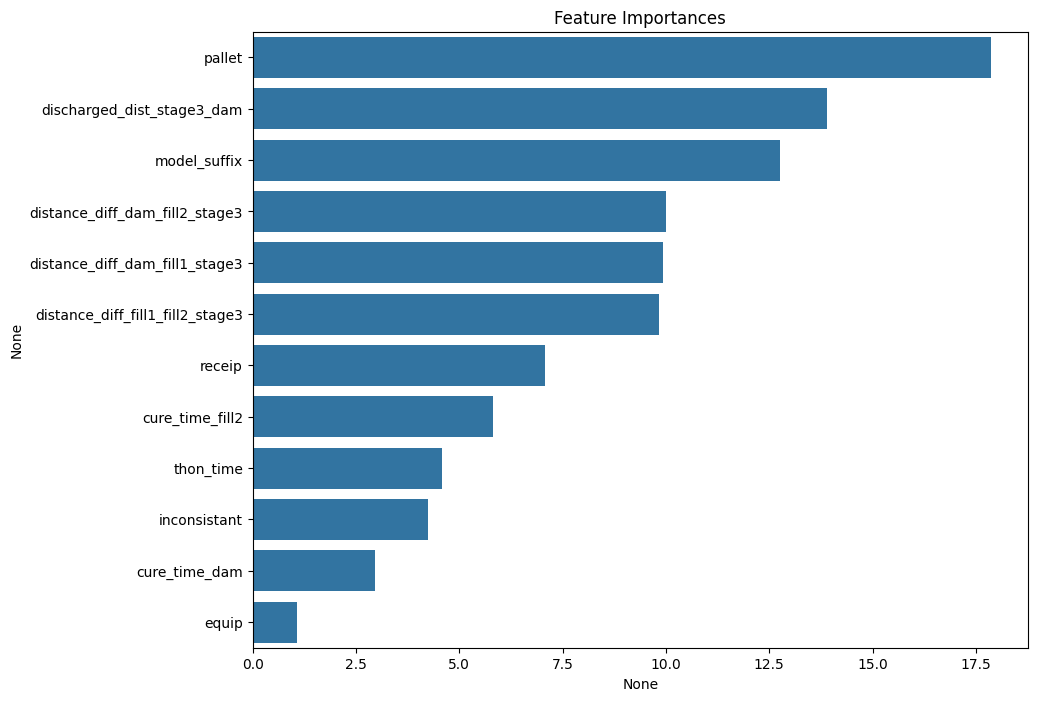

In [21]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(fill2_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [22]:
pred = fill2_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  73  385]
 [ 373 7271]]

정확도: 0.9064
정밀도: 0.1637
재현율: 0.1594
F1: 0.1615


# AutoClave

In [24]:
X_AutoClave = df_autoclave.drop(columns=['target'])
y_AutoClave = df_autoclave['target']

cat_features_indices_autoclave = ['pallet', 'receip', 'equip', 'model_suffix', 'chamber_temp']

X_train, X_valid, y_train, y_valid = train_test_split(X_AutoClave, y_AutoClave, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 1, 20),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-14 15:07:59,434] A new study created in memory with name: no-name-bf874bf9-9551-4d6e-abdf-9ab66bc456c3
[I 2024-08-14 15:08:02,842] Trial 0 finished with value: 0.5419605795861991 and parameters: {'iterations': 776, 'depth': 7, 'learning_rate': 0.6049588084581342, 'l2_leaf_reg': 8.196915142840268, 'border_count': 221, 'random_strength': 1.6896038752355491, 'bagging_temperature': 0.41132455354873787, 'od_type': 'Iter', 'od_wait': 29, 'boosting_type': 'Ordered', 'scale_pos_weight': 2}. Best is trial 0 with value: 0.5419605795861991.
[I 2024-08-14 15:08:05,294] Trial 1 finished with value: 0.5375559119882081 and parameters: {'iterations': 902, 'depth': 7, 'learning_rate': 0.5426463699104278, 'l2_leaf_reg': 8.40435933848275, 'border_count': 40, 'random_strength': 5.465477773349857, 'bagging_temperature': 0.49407135090054466, 'od_type': 'IncToDec', 'od_wait': 32, 'boosting_type': 'Ordered', 'scale_pos_weight': 10}. Best is trial 0 with value: 0.5419605795861991.
[I 2024-08-14 15:0

[I 2024-08-14 15:10:24,352] Trial 19 finished with value: 0.5319691766302044 and parameters: {'iterations': 551, 'depth': 4, 'learning_rate': 0.0027527544112091705, 'l2_leaf_reg': 5.482298329986803, 'border_count': 194, 'random_strength': 2.4126242482404625, 'bagging_temperature': 0.300471016352752, 'od_type': 'IncToDec', 'od_wait': 50, 'boosting_type': 'Ordered', 'scale_pos_weight': 5}. Best is trial 12 with value: 0.5596834531642639.
[I 2024-08-14 15:10:41,741] Trial 20 finished with value: 0.4145073418254565 and parameters: {'iterations': 951, 'depth': 5, 'learning_rate': 0.0168447271831494, 'l2_leaf_reg': 4.436528931578367, 'border_count': 144, 'random_strength': 6.636861621861941, 'bagging_temperature': 0.12555380691894613, 'od_type': 'IncToDec', 'od_wait': 23, 'boosting_type': 'Ordered', 'scale_pos_weight': 20}. Best is trial 12 with value: 0.5596834531642639.
[I 2024-08-14 15:10:47,779] Trial 21 finished with value: 0.5540770970318167 and parameters: {'iterations': 1000, 'depth'

[I 2024-08-14 15:12:21,610] Trial 38 finished with value: 0.5452847364052986 and parameters: {'iterations': 801, 'depth': 5, 'learning_rate': 0.9869301400177285, 'l2_leaf_reg': 8.813400140682212, 'border_count': 103, 'random_strength': 5.930776368450146, 'bagging_temperature': 0.479135794960755, 'od_type': 'IncToDec', 'od_wait': 30, 'boosting_type': 'Ordered', 'scale_pos_weight': 2}. Best is trial 12 with value: 0.5596834531642639.
[I 2024-08-14 15:12:25,114] Trial 39 finished with value: 0.545591690431621 and parameters: {'iterations': 864, 'depth': 6, 'learning_rate': 0.174535997871002, 'l2_leaf_reg': 9.465148754431784, 'border_count': 185, 'random_strength': 7.7696850930891825, 'bagging_temperature': 0.21835026515380906, 'od_type': 'Iter', 'od_wait': 38, 'boosting_type': 'Ordered', 'scale_pos_weight': 4}. Best is trial 12 with value: 0.5596834531642639.
[I 2024-08-14 15:12:37,062] Trial 40 finished with value: 0.5220191622926822 and parameters: {'iterations': 666, 'depth': 4, 'learn

Best trial:
  Value: 0.5596834531642639
  Params: 
    iterations: 981
    depth: 4
    learning_rate: 0.06853551846222596
    l2_leaf_reg: 9.4223248655118
    border_count: 110
    random_strength: 1.8867148287344069
    bagging_temperature: 0.011316475044150648
    od_type: IncToDec
    od_wait: 10
    boosting_type: Ordered
    scale_pos_weight: 7


In [25]:
study.best_trial.params

{'iterations': 981,
 'depth': 4,
 'learning_rate': 0.06853551846222596,
 'l2_leaf_reg': 9.4223248655118,
 'border_count': 110,
 'random_strength': 1.8867148287344069,
 'bagging_temperature': 0.011316475044150648,
 'od_type': 'IncToDec',
 'od_wait': 10,
 'boosting_type': 'Ordered',
 'scale_pos_weight': 7}

In [26]:
# 최적의 하이퍼파라미터로 모델 재학습
AutoClave_best_params = study.best_trial.params
AutoClave_best_model = CatBoostClassifier(**AutoClave_best_params)
AutoClave_best_model.fit(X_train, y_train, cat_features=cat_features_indices)

0:	learn: 0.6791878	total: 15.9ms	remaining: 15.6s
1:	learn: 0.6654935	total: 38.6ms	remaining: 18.9s
2:	learn: 0.6572649	total: 48.6ms	remaining: 15.8s
3:	learn: 0.6482564	total: 69.9ms	remaining: 17.1s
4:	learn: 0.6393597	total: 88.5ms	remaining: 17.3s
5:	learn: 0.6340465	total: 98.1ms	remaining: 15.9s
6:	learn: 0.6288022	total: 116ms	remaining: 16.2s
7:	learn: 0.6231021	total: 136ms	remaining: 16.6s
8:	learn: 0.6178357	total: 158ms	remaining: 17s
9:	learn: 0.6148058	total: 167ms	remaining: 16.3s
10:	learn: 0.6101999	total: 188ms	remaining: 16.6s
11:	learn: 0.6066405	total: 209ms	remaining: 16.9s
12:	learn: 0.6037773	total: 230ms	remaining: 17.1s
13:	learn: 0.6019724	total: 249ms	remaining: 17.2s
14:	learn: 0.6001929	total: 270ms	remaining: 17.4s
15:	learn: 0.5981697	total: 282ms	remaining: 17s
16:	learn: 0.5962508	total: 302ms	remaining: 17.1s
17:	learn: 0.5936129	total: 321ms	remaining: 17.2s
18:	learn: 0.5917069	total: 343ms	remaining: 17.3s
19:	learn: 0.5906289	total: 356ms	remai

164:	learn: 0.5706977	total: 2.87s	remaining: 14.2s
165:	learn: 0.5706247	total: 2.9s	remaining: 14.2s
166:	learn: 0.5706210	total: 2.91s	remaining: 14.2s
167:	learn: 0.5706210	total: 2.92s	remaining: 14.1s
168:	learn: 0.5705193	total: 2.94s	remaining: 14.1s
169:	learn: 0.5705181	total: 2.95s	remaining: 14.1s
170:	learn: 0.5703554	total: 2.97s	remaining: 14.1s
171:	learn: 0.5703400	total: 2.99s	remaining: 14.1s
172:	learn: 0.5701050	total: 3.01s	remaining: 14.1s
173:	learn: 0.5701050	total: 3.02s	remaining: 14s
174:	learn: 0.5698991	total: 3.04s	remaining: 14s
175:	learn: 0.5698834	total: 3.06s	remaining: 14s
176:	learn: 0.5695449	total: 3.08s	remaining: 14s
177:	learn: 0.5693898	total: 3.1s	remaining: 14s
178:	learn: 0.5692008	total: 3.13s	remaining: 14s
179:	learn: 0.5689269	total: 3.15s	remaining: 14s
180:	learn: 0.5686853	total: 3.17s	remaining: 14s
181:	learn: 0.5685305	total: 3.19s	remaining: 14s
182:	learn: 0.5684134	total: 3.21s	remaining: 14s
183:	learn: 0.5680910	total: 3.23s

323:	learn: 0.5531134	total: 6.09s	remaining: 12.3s
324:	learn: 0.5529876	total: 6.11s	remaining: 12.3s
325:	learn: 0.5529456	total: 6.13s	remaining: 12.3s
326:	learn: 0.5527892	total: 6.15s	remaining: 12.3s
327:	learn: 0.5527390	total: 6.17s	remaining: 12.3s
328:	learn: 0.5526788	total: 6.19s	remaining: 12.3s
329:	learn: 0.5526523	total: 6.21s	remaining: 12.2s
330:	learn: 0.5526158	total: 6.23s	remaining: 12.2s
331:	learn: 0.5524748	total: 6.25s	remaining: 12.2s
332:	learn: 0.5524638	total: 6.27s	remaining: 12.2s
333:	learn: 0.5524352	total: 6.29s	remaining: 12.2s
334:	learn: 0.5524086	total: 6.31s	remaining: 12.2s
335:	learn: 0.5523597	total: 6.33s	remaining: 12.2s
336:	learn: 0.5522737	total: 6.35s	remaining: 12.1s
337:	learn: 0.5521738	total: 6.37s	remaining: 12.1s
338:	learn: 0.5521484	total: 6.39s	remaining: 12.1s
339:	learn: 0.5521145	total: 6.42s	remaining: 12.1s
340:	learn: 0.5520916	total: 6.43s	remaining: 12.1s
341:	learn: 0.5520617	total: 6.45s	remaining: 12.1s
342:	learn: 

488:	learn: 0.5471229	total: 9.39s	remaining: 9.45s
489:	learn: 0.5471176	total: 9.41s	remaining: 9.43s
490:	learn: 0.5470755	total: 9.44s	remaining: 9.42s
491:	learn: 0.5470658	total: 9.46s	remaining: 9.4s
492:	learn: 0.5470421	total: 9.48s	remaining: 9.38s
493:	learn: 0.5470383	total: 9.5s	remaining: 9.36s
494:	learn: 0.5470298	total: 9.52s	remaining: 9.34s
495:	learn: 0.5469940	total: 9.54s	remaining: 9.32s
496:	learn: 0.5469342	total: 9.56s	remaining: 9.31s
497:	learn: 0.5468971	total: 9.57s	remaining: 9.29s
498:	learn: 0.5468344	total: 9.6s	remaining: 9.27s
499:	learn: 0.5468332	total: 9.62s	remaining: 9.25s
500:	learn: 0.5468243	total: 9.64s	remaining: 9.23s
501:	learn: 0.5468104	total: 9.66s	remaining: 9.21s
502:	learn: 0.5468088	total: 9.68s	remaining: 9.19s
503:	learn: 0.5468072	total: 9.7s	remaining: 9.18s
504:	learn: 0.5467835	total: 9.71s	remaining: 9.16s
505:	learn: 0.5467093	total: 9.73s	remaining: 9.14s
506:	learn: 0.5467060	total: 9.76s	remaining: 9.12s
507:	learn: 0.54

649:	learn: 0.5448375	total: 12.6s	remaining: 6.4s
650:	learn: 0.5448271	total: 12.6s	remaining: 6.38s
651:	learn: 0.5448256	total: 12.6s	remaining: 6.36s
652:	learn: 0.5448253	total: 12.6s	remaining: 6.34s
653:	learn: 0.5448250	total: 12.7s	remaining: 6.33s
654:	learn: 0.5447922	total: 12.7s	remaining: 6.31s
655:	learn: 0.5447695	total: 12.7s	remaining: 6.29s
656:	learn: 0.5447693	total: 12.7s	remaining: 6.27s
657:	learn: 0.5447584	total: 12.7s	remaining: 6.25s
658:	learn: 0.5447493	total: 12.7s	remaining: 6.23s
659:	learn: 0.5447463	total: 12.8s	remaining: 6.21s
660:	learn: 0.5447416	total: 12.8s	remaining: 6.19s
661:	learn: 0.5447388	total: 12.8s	remaining: 6.17s
662:	learn: 0.5447044	total: 12.8s	remaining: 6.15s
663:	learn: 0.5447020	total: 12.8s	remaining: 6.13s
664:	learn: 0.5446999	total: 12.9s	remaining: 6.11s
665:	learn: 0.5446974	total: 12.9s	remaining: 6.09s
666:	learn: 0.5446149	total: 12.9s	remaining: 6.08s
667:	learn: 0.5445807	total: 12.9s	remaining: 6.05s
668:	learn: 0

814:	learn: 0.5438180	total: 15.7s	remaining: 3.2s
815:	learn: 0.5438044	total: 15.7s	remaining: 3.18s
816:	learn: 0.5438037	total: 15.7s	remaining: 3.16s
817:	learn: 0.5437991	total: 15.8s	remaining: 3.14s
818:	learn: 0.5437978	total: 15.8s	remaining: 3.12s
819:	learn: 0.5437922	total: 15.8s	remaining: 3.1s
820:	learn: 0.5437913	total: 15.8s	remaining: 3.08s
821:	learn: 0.5437834	total: 15.8s	remaining: 3.06s
822:	learn: 0.5437833	total: 15.9s	remaining: 3.04s
823:	learn: 0.5437786	total: 15.9s	remaining: 3.02s
824:	learn: 0.5437734	total: 15.9s	remaining: 3.01s
825:	learn: 0.5437668	total: 15.9s	remaining: 2.99s
826:	learn: 0.5437666	total: 15.9s	remaining: 2.97s
827:	learn: 0.5437665	total: 16s	remaining: 2.95s
828:	learn: 0.5437658	total: 16s	remaining: 2.93s
829:	learn: 0.5437656	total: 16s	remaining: 2.91s
830:	learn: 0.5437644	total: 16s	remaining: 2.89s
831:	learn: 0.5437637	total: 16s	remaining: 2.87s
832:	learn: 0.5437637	total: 16s	remaining: 2.85s
833:	learn: 0.5437604	tota

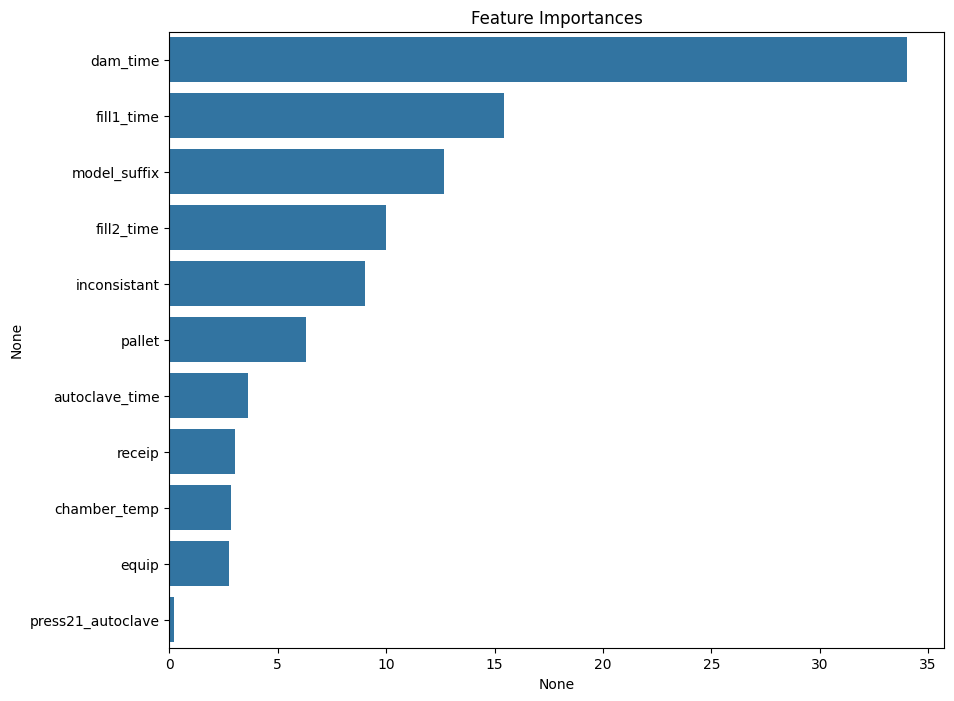

In [27]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(AutoClave_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [28]:
pred = AutoClave_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  37  421]
 [  65 7579]]

정확도: 0.9400
정밀도: 0.3627
재현율: 0.0808
F1: 0.1321


# 민감성

In [36]:
# 최적의 하이퍼파라미터로 모델 재학습
dam_best_params = study.best_trial.params
dam_best_model = CatBoostClassifier(**dam_best_params)
dam_best_model.fit(X_dam, y_dam, cat_features=cat_features_indices_dam)

# 최적의 하이퍼파라미터로 모델 재학습
fill1_best_params = study.best_trial.params
fill1_best_model = CatBoostClassifier(**fill1_best_params)
fill1_best_model.fit(X_fill1, y_fill1, cat_features=cat_features_indices_fill1)

# 최적의 하이퍼파라미터로 모델 재학습
fill2_best_params = study.best_trial.params
fill2_best_model = CatBoostClassifier(**fill2_best_params)
fill2_best_model.fit(X_fill2, y_fill2, cat_features=cat_features_indices_fill2)

# 최적의 하이퍼파라미터로 모델 재학습
AutoClave_best_params = study.best_trial.params
AutoClave_best_model = CatBoostClassifier(**AutoClave_best_params)
AutoClave_best_model.fit(X_AutoClave, y_AutoClave, cat_features=cat_features_indices_autoclave)

0:	learn: 0.6769472	total: 52.3ms	remaining: 51.3s
1:	learn: 0.6638530	total: 91.7ms	remaining: 44.9s
2:	learn: 0.6527204	total: 128ms	remaining: 41.6s
3:	learn: 0.6430687	total: 161ms	remaining: 39.3s
4:	learn: 0.6354876	total: 195ms	remaining: 38s
5:	learn: 0.6291525	total: 231ms	remaining: 37.5s
6:	learn: 0.6224260	total: 265ms	remaining: 36.9s
7:	learn: 0.6170221	total: 300ms	remaining: 36.4s
8:	learn: 0.6125990	total: 333ms	remaining: 35.9s
9:	learn: 0.6089716	total: 369ms	remaining: 35.8s
10:	learn: 0.6055258	total: 405ms	remaining: 35.7s
11:	learn: 0.6028602	total: 427ms	remaining: 34.5s
12:	learn: 0.6001968	total: 461ms	remaining: 34.3s
13:	learn: 0.5973962	total: 498ms	remaining: 34.4s
14:	learn: 0.5956993	total: 533ms	remaining: 34.3s
15:	learn: 0.5940105	total: 566ms	remaining: 34.1s
16:	learn: 0.5925989	total: 587ms	remaining: 33.3s
17:	learn: 0.5910716	total: 624ms	remaining: 33.4s
18:	learn: 0.5902253	total: 656ms	remaining: 33.2s
19:	learn: 0.5887595	total: 688ms	remaini

164:	learn: 0.5746732	total: 3.94s	remaining: 19.5s
165:	learn: 0.5745184	total: 3.95s	remaining: 19.4s
166:	learn: 0.5743093	total: 3.97s	remaining: 19.4s
167:	learn: 0.5743070	total: 3.99s	remaining: 19.3s
168:	learn: 0.5743045	total: 4s	remaining: 19.2s
169:	learn: 0.5741326	total: 4.02s	remaining: 19.2s
170:	learn: 0.5739988	total: 4.04s	remaining: 19.1s
171:	learn: 0.5739689	total: 4.06s	remaining: 19.1s
172:	learn: 0.5738229	total: 4.08s	remaining: 19.1s
173:	learn: 0.5737888	total: 4.09s	remaining: 19s
174:	learn: 0.5737133	total: 4.12s	remaining: 19s
175:	learn: 0.5735506	total: 4.14s	remaining: 18.9s
176:	learn: 0.5735506	total: 4.15s	remaining: 18.8s
177:	learn: 0.5735062	total: 4.17s	remaining: 18.8s
178:	learn: 0.5734110	total: 4.19s	remaining: 18.8s
179:	learn: 0.5733042	total: 4.21s	remaining: 18.7s
180:	learn: 0.5733033	total: 4.22s	remaining: 18.7s
181:	learn: 0.5730973	total: 4.24s	remaining: 18.6s
182:	learn: 0.5730594	total: 4.26s	remaining: 18.6s
183:	learn: 0.57297

332:	learn: 0.5670090	total: 7.08s	remaining: 13.8s
333:	learn: 0.5670071	total: 7.09s	remaining: 13.7s
334:	learn: 0.5670052	total: 7.11s	remaining: 13.7s
335:	learn: 0.5669844	total: 7.13s	remaining: 13.7s
336:	learn: 0.5669825	total: 7.15s	remaining: 13.7s
337:	learn: 0.5669796	total: 7.17s	remaining: 13.6s
338:	learn: 0.5669709	total: 7.18s	remaining: 13.6s
339:	learn: 0.5669535	total: 7.2s	remaining: 13.6s
340:	learn: 0.5669360	total: 7.22s	remaining: 13.6s
341:	learn: 0.5668104	total: 7.24s	remaining: 13.5s
342:	learn: 0.5668084	total: 7.26s	remaining: 13.5s
343:	learn: 0.5668070	total: 7.28s	remaining: 13.5s
344:	learn: 0.5668055	total: 7.29s	remaining: 13.4s
345:	learn: 0.5667983	total: 7.31s	remaining: 13.4s
346:	learn: 0.5667950	total: 7.33s	remaining: 13.4s
347:	learn: 0.5667690	total: 7.35s	remaining: 13.4s
348:	learn: 0.5667671	total: 7.37s	remaining: 13.3s
349:	learn: 0.5667646	total: 7.38s	remaining: 13.3s
350:	learn: 0.5667630	total: 7.4s	remaining: 13.3s
351:	learn: 0.

495:	learn: 0.5655835	total: 10s	remaining: 9.82s
496:	learn: 0.5655835	total: 10.1s	remaining: 9.8s
497:	learn: 0.5655834	total: 10.1s	remaining: 9.78s
498:	learn: 0.5655825	total: 10.1s	remaining: 9.75s
499:	learn: 0.5655823	total: 10.1s	remaining: 9.73s
500:	learn: 0.5655816	total: 10.1s	remaining: 9.71s
501:	learn: 0.5655684	total: 10.2s	remaining: 9.69s
502:	learn: 0.5655580	total: 10.2s	remaining: 9.67s
503:	learn: 0.5655300	total: 10.2s	remaining: 9.64s
504:	learn: 0.5654154	total: 10.2s	remaining: 9.62s
505:	learn: 0.5653786	total: 10.2s	remaining: 9.6s
506:	learn: 0.5653785	total: 10.2s	remaining: 9.58s
507:	learn: 0.5653780	total: 10.3s	remaining: 9.56s
508:	learn: 0.5653777	total: 10.3s	remaining: 9.53s
509:	learn: 0.5653775	total: 10.3s	remaining: 9.51s
510:	learn: 0.5653774	total: 10.3s	remaining: 9.49s
511:	learn: 0.5653737	total: 10.3s	remaining: 9.47s
512:	learn: 0.5653737	total: 10.4s	remaining: 9.44s
513:	learn: 0.5653713	total: 10.4s	remaining: 9.42s
514:	learn: 0.56

659:	learn: 0.5638036	total: 13s	remaining: 6.31s
660:	learn: 0.5637786	total: 13s	remaining: 6.29s
661:	learn: 0.5637786	total: 13s	remaining: 6.27s
662:	learn: 0.5637780	total: 13s	remaining: 6.25s
663:	learn: 0.5637768	total: 13s	remaining: 6.23s
664:	learn: 0.5637558	total: 13.1s	remaining: 6.21s
665:	learn: 0.5637557	total: 13.1s	remaining: 6.19s
666:	learn: 0.5636600	total: 13.1s	remaining: 6.17s
667:	learn: 0.5636599	total: 13.1s	remaining: 6.14s
668:	learn: 0.5635915	total: 13.1s	remaining: 6.13s
669:	learn: 0.5635829	total: 13.2s	remaining: 6.1s
670:	learn: 0.5635757	total: 13.2s	remaining: 6.08s
671:	learn: 0.5635622	total: 13.2s	remaining: 6.07s
672:	learn: 0.5635383	total: 13.2s	remaining: 6.04s
673:	learn: 0.5635383	total: 13.2s	remaining: 6.02s
674:	learn: 0.5635383	total: 13.2s	remaining: 6s
675:	learn: 0.5635218	total: 13.3s	remaining: 5.98s
676:	learn: 0.5634948	total: 13.3s	remaining: 5.96s
677:	learn: 0.5634945	total: 13.3s	remaining: 5.94s
678:	learn: 0.5634931	tota

826:	learn: 0.5619362	total: 15.9s	remaining: 2.97s
827:	learn: 0.5619354	total: 15.9s	remaining: 2.95s
828:	learn: 0.5619320	total: 16s	remaining: 2.93s
829:	learn: 0.5619319	total: 16s	remaining: 2.91s
830:	learn: 0.5619262	total: 16s	remaining: 2.89s
831:	learn: 0.5619260	total: 16s	remaining: 2.87s
832:	learn: 0.5618964	total: 16s	remaining: 2.85s
833:	learn: 0.5618709	total: 16.1s	remaining: 2.83s
834:	learn: 0.5618707	total: 16.1s	remaining: 2.81s
835:	learn: 0.5618484	total: 16.1s	remaining: 2.79s
836:	learn: 0.5618482	total: 16.1s	remaining: 2.77s
837:	learn: 0.5618274	total: 16.1s	remaining: 2.75s
838:	learn: 0.5617818	total: 16.1s	remaining: 2.73s
839:	learn: 0.5617681	total: 16.2s	remaining: 2.71s
840:	learn: 0.5617528	total: 16.2s	remaining: 2.69s
841:	learn: 0.5617436	total: 16.2s	remaining: 2.67s
842:	learn: 0.5617435	total: 16.2s	remaining: 2.65s
843:	learn: 0.5617253	total: 16.2s	remaining: 2.64s
844:	learn: 0.5617225	total: 16.3s	remaining: 2.62s
845:	learn: 0.5617139	

11:	learn: 0.6031171	total: 234ms	remaining: 18.9s
12:	learn: 0.6011701	total: 248ms	remaining: 18.5s
13:	learn: 0.5991017	total: 268ms	remaining: 18.5s
14:	learn: 0.5973900	total: 286ms	remaining: 18.4s
15:	learn: 0.5954623	total: 305ms	remaining: 18.4s
16:	learn: 0.5943728	total: 320ms	remaining: 18.1s
17:	learn: 0.5923813	total: 339ms	remaining: 18.1s
18:	learn: 0.5910762	total: 357ms	remaining: 18.1s
19:	learn: 0.5894797	total: 376ms	remaining: 18.1s
20:	learn: 0.5882198	total: 398ms	remaining: 18.2s
21:	learn: 0.5870280	total: 418ms	remaining: 18.2s
22:	learn: 0.5858032	total: 440ms	remaining: 18.3s
23:	learn: 0.5850089	total: 459ms	remaining: 18.3s
24:	learn: 0.5839310	total: 479ms	remaining: 18.3s
25:	learn: 0.5835511	total: 491ms	remaining: 18s
26:	learn: 0.5831349	total: 512ms	remaining: 18.1s
27:	learn: 0.5825626	total: 532ms	remaining: 18.1s
28:	learn: 0.5822611	total: 551ms	remaining: 18.1s
29:	learn: 0.5816939	total: 571ms	remaining: 18.1s
30:	learn: 0.5812864	total: 591ms

181:	learn: 0.5712663	total: 3.12s	remaining: 13.7s
182:	learn: 0.5711254	total: 3.14s	remaining: 13.7s
183:	learn: 0.5710467	total: 3.16s	remaining: 13.7s
184:	learn: 0.5708313	total: 3.18s	remaining: 13.7s
185:	learn: 0.5706169	total: 3.2s	remaining: 13.7s
186:	learn: 0.5705089	total: 3.22s	remaining: 13.7s
187:	learn: 0.5703048	total: 3.24s	remaining: 13.7s
188:	learn: 0.5699459	total: 3.26s	remaining: 13.7s
189:	learn: 0.5698791	total: 3.28s	remaining: 13.7s
190:	learn: 0.5697889	total: 3.3s	remaining: 13.7s
191:	learn: 0.5696044	total: 3.32s	remaining: 13.7s
192:	learn: 0.5694182	total: 3.34s	remaining: 13.6s
193:	learn: 0.5690703	total: 3.36s	remaining: 13.6s
194:	learn: 0.5688740	total: 3.38s	remaining: 13.6s
195:	learn: 0.5688122	total: 3.4s	remaining: 13.6s
196:	learn: 0.5687324	total: 3.42s	remaining: 13.6s
197:	learn: 0.5685281	total: 3.44s	remaining: 13.6s
198:	learn: 0.5684709	total: 3.46s	remaining: 13.6s
199:	learn: 0.5681628	total: 3.48s	remaining: 13.6s
200:	learn: 0.5

345:	learn: 0.5615528	total: 6.27s	remaining: 11.5s
346:	learn: 0.5615177	total: 6.29s	remaining: 11.5s
347:	learn: 0.5614772	total: 6.3s	remaining: 11.5s
348:	learn: 0.5614753	total: 6.32s	remaining: 11.4s
349:	learn: 0.5614665	total: 6.34s	remaining: 11.4s
350:	learn: 0.5614585	total: 6.36s	remaining: 11.4s
351:	learn: 0.5613981	total: 6.38s	remaining: 11.4s
352:	learn: 0.5613913	total: 6.4s	remaining: 11.4s
353:	learn: 0.5613721	total: 6.42s	remaining: 11.4s
354:	learn: 0.5613106	total: 6.43s	remaining: 11.3s
355:	learn: 0.5612902	total: 6.45s	remaining: 11.3s
356:	learn: 0.5612743	total: 6.47s	remaining: 11.3s
357:	learn: 0.5612600	total: 6.49s	remaining: 11.3s
358:	learn: 0.5612562	total: 6.51s	remaining: 11.3s
359:	learn: 0.5612332	total: 6.53s	remaining: 11.3s
360:	learn: 0.5612307	total: 6.55s	remaining: 11.2s
361:	learn: 0.5612234	total: 6.57s	remaining: 11.2s
362:	learn: 0.5611860	total: 6.58s	remaining: 11.2s
363:	learn: 0.5611760	total: 6.6s	remaining: 11.2s
364:	learn: 0.5

510:	learn: 0.5586110	total: 9.33s	remaining: 8.58s
511:	learn: 0.5586059	total: 9.35s	remaining: 8.56s
512:	learn: 0.5586029	total: 9.37s	remaining: 8.54s
513:	learn: 0.5585994	total: 9.38s	remaining: 8.53s
514:	learn: 0.5585916	total: 9.4s	remaining: 8.51s
515:	learn: 0.5585404	total: 9.42s	remaining: 8.49s
516:	learn: 0.5585385	total: 9.44s	remaining: 8.47s
517:	learn: 0.5585359	total: 9.46s	remaining: 8.46s
518:	learn: 0.5585342	total: 9.48s	remaining: 8.44s
519:	learn: 0.5585326	total: 9.49s	remaining: 8.42s
520:	learn: 0.5585276	total: 9.51s	remaining: 8.4s
521:	learn: 0.5585211	total: 9.53s	remaining: 8.38s
522:	learn: 0.5585151	total: 9.55s	remaining: 8.36s
523:	learn: 0.5585019	total: 9.57s	remaining: 8.35s
524:	learn: 0.5584968	total: 9.59s	remaining: 8.33s
525:	learn: 0.5584543	total: 9.61s	remaining: 8.31s
526:	learn: 0.5584323	total: 9.62s	remaining: 8.29s
527:	learn: 0.5584132	total: 9.64s	remaining: 8.27s
528:	learn: 0.5584027	total: 9.66s	remaining: 8.25s
529:	learn: 0.

671:	learn: 0.5570272	total: 12.3s	remaining: 5.63s
672:	learn: 0.5570264	total: 12.3s	remaining: 5.62s
673:	learn: 0.5570257	total: 12.3s	remaining: 5.6s
674:	learn: 0.5570209	total: 12.3s	remaining: 5.58s
675:	learn: 0.5570188	total: 12.3s	remaining: 5.56s
676:	learn: 0.5570105	total: 12.3s	remaining: 5.54s
677:	learn: 0.5570061	total: 12.4s	remaining: 5.52s
678:	learn: 0.5569992	total: 12.4s	remaining: 5.5s
679:	learn: 0.5569955	total: 12.4s	remaining: 5.49s
680:	learn: 0.5569936	total: 12.4s	remaining: 5.47s
681:	learn: 0.5569920	total: 12.4s	remaining: 5.45s
682:	learn: 0.5569887	total: 12.4s	remaining: 5.43s
683:	learn: 0.5569843	total: 12.5s	remaining: 5.41s
684:	learn: 0.5569823	total: 12.5s	remaining: 5.39s
685:	learn: 0.5569763	total: 12.5s	remaining: 5.38s
686:	learn: 0.5569717	total: 12.5s	remaining: 5.36s
687:	learn: 0.5569698	total: 12.5s	remaining: 5.34s
688:	learn: 0.5569680	total: 12.6s	remaining: 5.32s
689:	learn: 0.5569675	total: 12.6s	remaining: 5.3s
690:	learn: 0.5

836:	learn: 0.5562135	total: 15.2s	remaining: 2.62s
837:	learn: 0.5562067	total: 15.2s	remaining: 2.6s
838:	learn: 0.5562051	total: 15.3s	remaining: 2.58s
839:	learn: 0.5562036	total: 15.3s	remaining: 2.56s
840:	learn: 0.5562036	total: 15.3s	remaining: 2.54s
841:	learn: 0.5562036	total: 15.3s	remaining: 2.53s
842:	learn: 0.5562036	total: 15.3s	remaining: 2.51s
843:	learn: 0.5562036	total: 15.3s	remaining: 2.49s
844:	learn: 0.5562022	total: 15.4s	remaining: 2.47s
845:	learn: 0.5562022	total: 15.4s	remaining: 2.45s
846:	learn: 0.5561947	total: 15.4s	remaining: 2.44s
847:	learn: 0.5561943	total: 15.4s	remaining: 2.42s
848:	learn: 0.5561943	total: 15.4s	remaining: 2.4s
849:	learn: 0.5561711	total: 15.5s	remaining: 2.38s
850:	learn: 0.5561711	total: 15.5s	remaining: 2.36s
851:	learn: 0.5561711	total: 15.5s	remaining: 2.34s
852:	learn: 0.5561492	total: 15.5s	remaining: 2.33s
853:	learn: 0.5561476	total: 15.5s	remaining: 2.31s
854:	learn: 0.5561474	total: 15.5s	remaining: 2.29s
855:	learn: 0.

15:	learn: 0.5938444	total: 315ms	remaining: 19s
16:	learn: 0.5924587	total: 328ms	remaining: 18.6s
17:	learn: 0.5910116	total: 349ms	remaining: 18.7s
18:	learn: 0.5898333	total: 369ms	remaining: 18.7s
19:	learn: 0.5884407	total: 386ms	remaining: 18.6s
20:	learn: 0.5872136	total: 405ms	remaining: 18.5s
21:	learn: 0.5862450	total: 424ms	remaining: 18.5s
22:	learn: 0.5855586	total: 437ms	remaining: 18.2s
23:	learn: 0.5846362	total: 459ms	remaining: 18.3s
24:	learn: 0.5841830	total: 474ms	remaining: 18.1s
25:	learn: 0.5837443	total: 494ms	remaining: 18.1s
26:	learn: 0.5832898	total: 515ms	remaining: 18.2s
27:	learn: 0.5824411	total: 537ms	remaining: 18.3s
28:	learn: 0.5821330	total: 558ms	remaining: 18.3s
29:	learn: 0.5815182	total: 577ms	remaining: 18.3s
30:	learn: 0.5811366	total: 595ms	remaining: 18.2s
31:	learn: 0.5809747	total: 613ms	remaining: 18.2s
32:	learn: 0.5806271	total: 634ms	remaining: 18.2s
33:	learn: 0.5802672	total: 653ms	remaining: 18.2s
34:	learn: 0.5801599	total: 670ms

187:	learn: 0.5726154	total: 3.23s	remaining: 13.6s
188:	learn: 0.5725437	total: 3.25s	remaining: 13.6s
189:	learn: 0.5724527	total: 3.27s	remaining: 13.6s
190:	learn: 0.5722497	total: 3.29s	remaining: 13.6s
191:	learn: 0.5721719	total: 3.31s	remaining: 13.6s
192:	learn: 0.5721139	total: 3.33s	remaining: 13.6s
193:	learn: 0.5718838	total: 3.35s	remaining: 13.6s
194:	learn: 0.5717179	total: 3.37s	remaining: 13.6s
195:	learn: 0.5716531	total: 3.39s	remaining: 13.6s
196:	learn: 0.5712007	total: 3.41s	remaining: 13.6s
197:	learn: 0.5710722	total: 3.43s	remaining: 13.6s
198:	learn: 0.5708905	total: 3.45s	remaining: 13.5s
199:	learn: 0.5706575	total: 3.47s	remaining: 13.5s
200:	learn: 0.5705009	total: 3.49s	remaining: 13.5s
201:	learn: 0.5704581	total: 3.51s	remaining: 13.5s
202:	learn: 0.5704261	total: 3.52s	remaining: 13.5s
203:	learn: 0.5703458	total: 3.54s	remaining: 13.5s
204:	learn: 0.5702036	total: 3.56s	remaining: 13.5s
205:	learn: 0.5699879	total: 3.58s	remaining: 13.5s
206:	learn: 

352:	learn: 0.5622607	total: 6.39s	remaining: 11.4s
353:	learn: 0.5622577	total: 6.41s	remaining: 11.4s
354:	learn: 0.5622501	total: 6.43s	remaining: 11.3s
355:	learn: 0.5622016	total: 6.45s	remaining: 11.3s
356:	learn: 0.5621651	total: 6.47s	remaining: 11.3s
357:	learn: 0.5621484	total: 6.49s	remaining: 11.3s
358:	learn: 0.5621286	total: 6.5s	remaining: 11.3s
359:	learn: 0.5621233	total: 6.52s	remaining: 11.3s
360:	learn: 0.5621209	total: 6.54s	remaining: 11.2s
361:	learn: 0.5620779	total: 6.56s	remaining: 11.2s
362:	learn: 0.5620569	total: 6.58s	remaining: 11.2s
363:	learn: 0.5618919	total: 6.6s	remaining: 11.2s
364:	learn: 0.5618777	total: 6.62s	remaining: 11.2s
365:	learn: 0.5618740	total: 6.64s	remaining: 11.2s
366:	learn: 0.5618623	total: 6.66s	remaining: 11.1s
367:	learn: 0.5618420	total: 6.67s	remaining: 11.1s
368:	learn: 0.5618395	total: 6.69s	remaining: 11.1s
369:	learn: 0.5618348	total: 6.71s	remaining: 11.1s
370:	learn: 0.5618265	total: 6.73s	remaining: 11.1s
371:	learn: 0.

517:	learn: 0.5595506	total: 9.5s	remaining: 8.49s
518:	learn: 0.5595483	total: 9.52s	remaining: 8.47s
519:	learn: 0.5595432	total: 9.54s	remaining: 8.46s
520:	learn: 0.5595386	total: 9.55s	remaining: 8.44s
521:	learn: 0.5595319	total: 9.57s	remaining: 8.42s
522:	learn: 0.5595247	total: 9.59s	remaining: 8.4s
523:	learn: 0.5594614	total: 9.61s	remaining: 8.38s
524:	learn: 0.5594553	total: 9.63s	remaining: 8.37s
525:	learn: 0.5594551	total: 9.65s	remaining: 8.35s
526:	learn: 0.5594497	total: 9.67s	remaining: 8.33s
527:	learn: 0.5594455	total: 9.68s	remaining: 8.31s
528:	learn: 0.5593944	total: 9.7s	remaining: 8.29s
529:	learn: 0.5593905	total: 9.72s	remaining: 8.27s
530:	learn: 0.5593461	total: 9.74s	remaining: 8.26s
531:	learn: 0.5593336	total: 9.76s	remaining: 8.24s
532:	learn: 0.5592978	total: 9.78s	remaining: 8.22s
533:	learn: 0.5591792	total: 9.8s	remaining: 8.2s
534:	learn: 0.5591733	total: 9.82s	remaining: 8.19s
535:	learn: 0.5591534	total: 9.84s	remaining: 8.17s
536:	learn: 0.559

685:	learn: 0.5579322	total: 12.6s	remaining: 5.42s
686:	learn: 0.5579318	total: 12.6s	remaining: 5.41s
687:	learn: 0.5579293	total: 12.6s	remaining: 5.39s
688:	learn: 0.5579249	total: 12.7s	remaining: 5.37s
689:	learn: 0.5579219	total: 12.7s	remaining: 5.35s
690:	learn: 0.5579217	total: 12.7s	remaining: 5.33s
691:	learn: 0.5579112	total: 12.7s	remaining: 5.31s
692:	learn: 0.5579022	total: 12.7s	remaining: 5.29s
693:	learn: 0.5579010	total: 12.8s	remaining: 5.28s
694:	learn: 0.5579004	total: 12.8s	remaining: 5.26s
695:	learn: 0.5579003	total: 12.8s	remaining: 5.24s
696:	learn: 0.5579001	total: 12.8s	remaining: 5.22s
697:	learn: 0.5578990	total: 12.8s	remaining: 5.2s
698:	learn: 0.5578404	total: 12.8s	remaining: 5.18s
699:	learn: 0.5578394	total: 12.9s	remaining: 5.16s
700:	learn: 0.5578390	total: 12.9s	remaining: 5.15s
701:	learn: 0.5578390	total: 12.9s	remaining: 5.13s
702:	learn: 0.5578389	total: 12.9s	remaining: 5.11s
703:	learn: 0.5578372	total: 12.9s	remaining: 5.09s
704:	learn: 0

846:	learn: 0.5571688	total: 15.5s	remaining: 2.46s
847:	learn: 0.5571686	total: 15.5s	remaining: 2.44s
848:	learn: 0.5571677	total: 15.6s	remaining: 2.42s
849:	learn: 0.5571677	total: 15.6s	remaining: 2.4s
850:	learn: 0.5571677	total: 15.6s	remaining: 2.38s
851:	learn: 0.5571658	total: 15.6s	remaining: 2.36s
852:	learn: 0.5571531	total: 15.6s	remaining: 2.35s
853:	learn: 0.5571522	total: 15.6s	remaining: 2.33s
854:	learn: 0.5571520	total: 15.7s	remaining: 2.31s
855:	learn: 0.5571496	total: 15.7s	remaining: 2.29s
856:	learn: 0.5571495	total: 15.7s	remaining: 2.27s
857:	learn: 0.5571479	total: 15.7s	remaining: 2.25s
858:	learn: 0.5571477	total: 15.7s	remaining: 2.23s
859:	learn: 0.5571399	total: 15.8s	remaining: 2.22s
860:	learn: 0.5571398	total: 15.8s	remaining: 2.2s
861:	learn: 0.5571397	total: 15.8s	remaining: 2.18s
862:	learn: 0.5571396	total: 15.8s	remaining: 2.16s
863:	learn: 0.5571387	total: 15.8s	remaining: 2.14s
864:	learn: 0.5571368	total: 15.8s	remaining: 2.12s
865:	learn: 0.

25:	learn: 0.5844914	total: 503ms	remaining: 18.5s
26:	learn: 0.5838412	total: 528ms	remaining: 18.7s
27:	learn: 0.5831798	total: 551ms	remaining: 18.8s
28:	learn: 0.5823716	total: 575ms	remaining: 18.9s
29:	learn: 0.5816020	total: 596ms	remaining: 18.9s
30:	learn: 0.5811891	total: 617ms	remaining: 18.9s
31:	learn: 0.5810573	total: 631ms	remaining: 18.7s
32:	learn: 0.5806195	total: 655ms	remaining: 18.8s
33:	learn: 0.5804711	total: 675ms	remaining: 18.8s
34:	learn: 0.5803180	total: 687ms	remaining: 18.6s
35:	learn: 0.5798296	total: 708ms	remaining: 18.6s
36:	learn: 0.5797676	total: 718ms	remaining: 18.3s
37:	learn: 0.5794899	total: 739ms	remaining: 18.3s
38:	learn: 0.5793689	total: 755ms	remaining: 18.2s
39:	learn: 0.5792845	total: 774ms	remaining: 18.2s
40:	learn: 0.5791339	total: 794ms	remaining: 18.2s
41:	learn: 0.5790859	total: 813ms	remaining: 18.2s
42:	learn: 0.5790028	total: 833ms	remaining: 18.2s
43:	learn: 0.5789392	total: 853ms	remaining: 18.2s
44:	learn: 0.5789036	total: 873

194:	learn: 0.5685830	total: 3.46s	remaining: 13.9s
195:	learn: 0.5685223	total: 3.48s	remaining: 13.9s
196:	learn: 0.5683877	total: 3.5s	remaining: 13.9s
197:	learn: 0.5682500	total: 3.52s	remaining: 13.9s
198:	learn: 0.5680378	total: 3.55s	remaining: 13.9s
199:	learn: 0.5679100	total: 3.57s	remaining: 13.9s
200:	learn: 0.5677300	total: 3.59s	remaining: 13.9s
201:	learn: 0.5675510	total: 3.61s	remaining: 13.9s
202:	learn: 0.5674057	total: 3.63s	remaining: 13.9s
203:	learn: 0.5672175	total: 3.65s	remaining: 13.9s
204:	learn: 0.5669903	total: 3.67s	remaining: 13.9s
205:	learn: 0.5668141	total: 3.7s	remaining: 13.9s
206:	learn: 0.5667128	total: 3.72s	remaining: 13.9s
207:	learn: 0.5665495	total: 3.74s	remaining: 13.9s
208:	learn: 0.5663611	total: 3.76s	remaining: 13.9s
209:	learn: 0.5662081	total: 3.78s	remaining: 13.9s
210:	learn: 0.5660936	total: 3.81s	remaining: 13.9s
211:	learn: 0.5659957	total: 3.83s	remaining: 13.9s
212:	learn: 0.5659393	total: 3.85s	remaining: 13.9s
213:	learn: 0.

356:	learn: 0.5594282	total: 6.83s	remaining: 11.9s
357:	learn: 0.5594046	total: 6.85s	remaining: 11.9s
358:	learn: 0.5593912	total: 6.87s	remaining: 11.9s
359:	learn: 0.5592099	total: 6.89s	remaining: 11.9s
360:	learn: 0.5592074	total: 6.91s	remaining: 11.9s
361:	learn: 0.5592002	total: 6.93s	remaining: 11.9s
362:	learn: 0.5590565	total: 6.95s	remaining: 11.8s
363:	learn: 0.5590301	total: 6.97s	remaining: 11.8s
364:	learn: 0.5590076	total: 6.99s	remaining: 11.8s
365:	learn: 0.5589926	total: 7.01s	remaining: 11.8s
366:	learn: 0.5589395	total: 7.04s	remaining: 11.8s
367:	learn: 0.5589101	total: 7.06s	remaining: 11.8s
368:	learn: 0.5588958	total: 7.08s	remaining: 11.7s
369:	learn: 0.5588729	total: 7.1s	remaining: 11.7s
370:	learn: 0.5588331	total: 7.12s	remaining: 11.7s
371:	learn: 0.5587348	total: 7.14s	remaining: 11.7s
372:	learn: 0.5587266	total: 7.16s	remaining: 11.7s
373:	learn: 0.5587121	total: 7.18s	remaining: 11.7s
374:	learn: 0.5587055	total: 7.2s	remaining: 11.6s
375:	learn: 0.

523:	learn: 0.5555210	total: 10.2s	remaining: 8.89s
524:	learn: 0.5555065	total: 10.2s	remaining: 8.87s
525:	learn: 0.5555022	total: 10.2s	remaining: 8.85s
526:	learn: 0.5554638	total: 10.3s	remaining: 8.83s
527:	learn: 0.5554423	total: 10.3s	remaining: 8.81s
528:	learn: 0.5554331	total: 10.3s	remaining: 8.79s
529:	learn: 0.5554298	total: 10.3s	remaining: 8.78s
530:	learn: 0.5554285	total: 10.3s	remaining: 8.76s
531:	learn: 0.5554279	total: 10.4s	remaining: 8.74s
532:	learn: 0.5554065	total: 10.4s	remaining: 8.72s
533:	learn: 0.5554035	total: 10.4s	remaining: 8.7s
534:	learn: 0.5554029	total: 10.4s	remaining: 8.68s
535:	learn: 0.5553899	total: 10.4s	remaining: 8.66s
536:	learn: 0.5553657	total: 10.5s	remaining: 8.64s
537:	learn: 0.5553135	total: 10.5s	remaining: 8.63s
538:	learn: 0.5552886	total: 10.5s	remaining: 8.61s
539:	learn: 0.5552882	total: 10.5s	remaining: 8.59s
540:	learn: 0.5552179	total: 10.5s	remaining: 8.57s
541:	learn: 0.5551667	total: 10.6s	remaining: 8.55s
542:	learn: 0

692:	learn: 0.5536291	total: 13.6s	remaining: 5.64s
693:	learn: 0.5536285	total: 13.6s	remaining: 5.62s
694:	learn: 0.5536258	total: 13.6s	remaining: 5.6s
695:	learn: 0.5536245	total: 13.6s	remaining: 5.58s
696:	learn: 0.5536228	total: 13.7s	remaining: 5.56s
697:	learn: 0.5536224	total: 13.7s	remaining: 5.54s
698:	learn: 0.5536171	total: 13.7s	remaining: 5.52s
699:	learn: 0.5536158	total: 13.7s	remaining: 5.5s
700:	learn: 0.5536093	total: 13.7s	remaining: 5.48s
701:	learn: 0.5535745	total: 13.7s	remaining: 5.46s
702:	learn: 0.5535711	total: 13.8s	remaining: 5.45s
703:	learn: 0.5535688	total: 13.8s	remaining: 5.42s
704:	learn: 0.5535384	total: 13.8s	remaining: 5.41s
705:	learn: 0.5535369	total: 13.8s	remaining: 5.39s
706:	learn: 0.5535367	total: 13.8s	remaining: 5.37s
707:	learn: 0.5535364	total: 13.9s	remaining: 5.35s
708:	learn: 0.5534830	total: 13.9s	remaining: 5.33s
709:	learn: 0.5534622	total: 13.9s	remaining: 5.31s
710:	learn: 0.5534578	total: 13.9s	remaining: 5.29s
711:	learn: 0.

856:	learn: 0.5524288	total: 16.9s	remaining: 2.44s
857:	learn: 0.5524253	total: 16.9s	remaining: 2.42s
858:	learn: 0.5524230	total: 16.9s	remaining: 2.4s
859:	learn: 0.5524216	total: 16.9s	remaining: 2.38s
860:	learn: 0.5523960	total: 17s	remaining: 2.36s
861:	learn: 0.5523947	total: 17s	remaining: 2.34s
862:	learn: 0.5523940	total: 17s	remaining: 2.32s
863:	learn: 0.5523901	total: 17s	remaining: 2.3s
864:	learn: 0.5523896	total: 17s	remaining: 2.28s
865:	learn: 0.5523588	total: 17s	remaining: 2.26s
866:	learn: 0.5523417	total: 17.1s	remaining: 2.24s
867:	learn: 0.5523413	total: 17.1s	remaining: 2.22s
868:	learn: 0.5523363	total: 17.1s	remaining: 2.21s
869:	learn: 0.5523293	total: 17.1s	remaining: 2.19s
870:	learn: 0.5523217	total: 17.1s	remaining: 2.17s
871:	learn: 0.5523197	total: 17.2s	remaining: 2.15s
872:	learn: 0.5523193	total: 17.2s	remaining: 2.13s
873:	learn: 0.5523187	total: 17.2s	remaining: 2.11s
874:	learn: 0.5523173	total: 17.2s	remaining: 2.09s
875:	learn: 0.5523127	tota

In [37]:
test_dam_x = test[X_dam.columns]
test_fill1_x = test[X_fill1.columns]
test_fill2_x = test[X_fill2.columns]
test_AutoClave_x = test[X_AutoClave.columns]

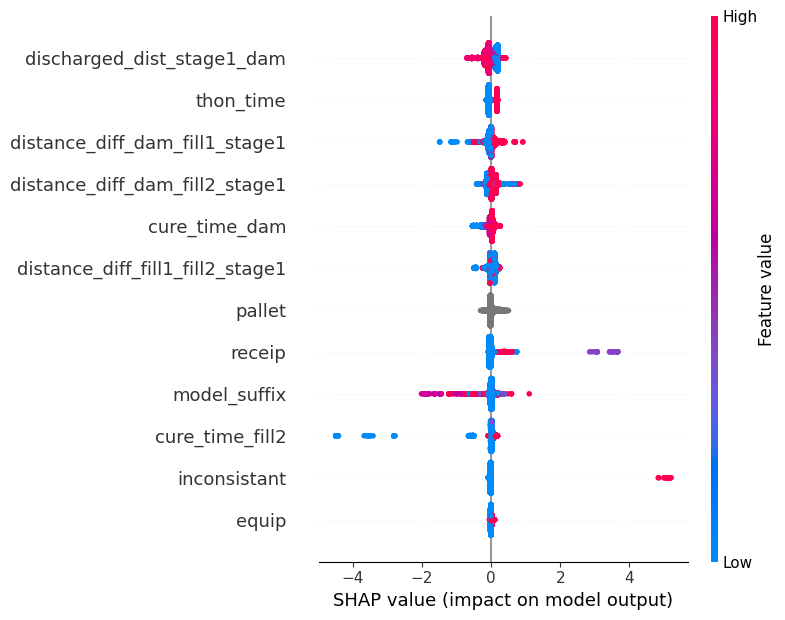

In [38]:
explainer = shap.Explainer(dam_best_model)
shap_values = explainer(test_dam_x)
shap.initjs()

shap.summary_plot(shap_values, test_dam_x)

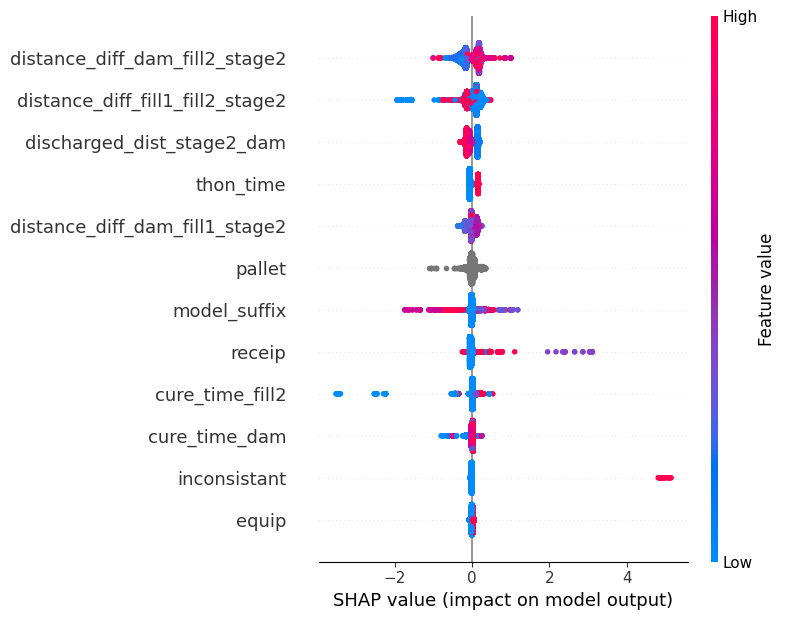

In [39]:
explainer = shap.Explainer(fill1_best_model)
shap_values = explainer(test_fill1_x)
shap.initjs()

shap.summary_plot(shap_values, test_fill1_x)

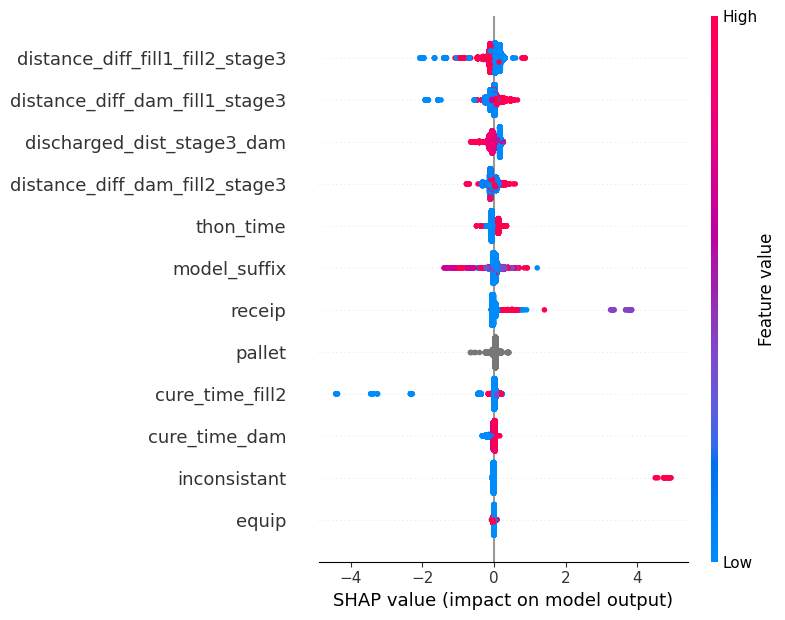

In [40]:
explainer = shap.Explainer(fill2_best_model)
shap_values = explainer(test_fill2_x)
shap.initjs()

shap.summary_plot(shap_values, test_fill2_x)

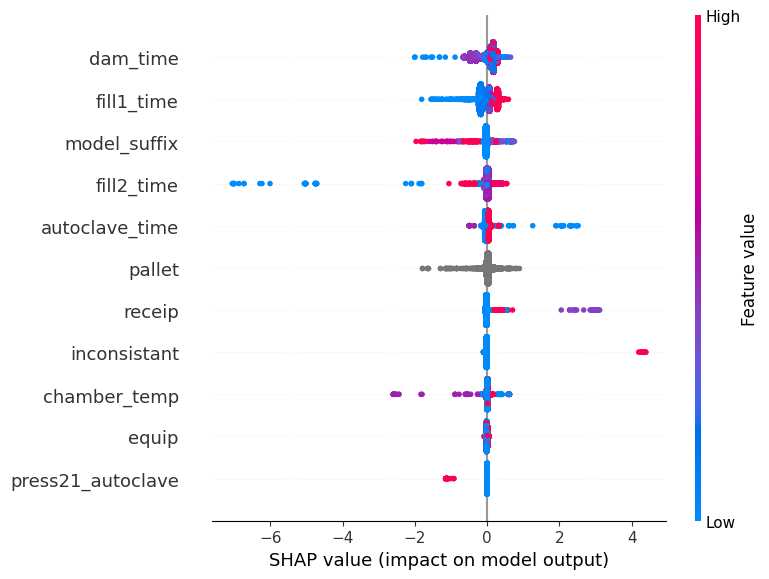

In [41]:
explainer = shap.Explainer(AutoClave_best_model)
shap_values = explainer(test_AutoClave_x)
shap.initjs()

shap.summary_plot(shap_values, test_AutoClave_x)

In [42]:
dam_test_pred = dam_best_model.predict(test_dam_x)
dam_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [43]:
fill1_test_pred = fill1_best_model.predict(test_fill1_x)
fill1_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
fill2_test_pred = fill2_best_model.predict(test_fill2_x)
fill2_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [45]:
AutoClave_test_pred = AutoClave_best_model.predict(test_AutoClave_x)
AutoClave_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [52]:
result = np.logical_or(dam_test_pred, fill1_test_pred)
result = np.logical_or(result, fill2_test_pred)
result = np.logical_or(result, AutoClave_test_pred)

In [53]:
y_pred = np.where(result == 1, "AbNormal", "Normal")

In [54]:
np.unique(y_pred, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([  368, 16993]))

In [55]:
test['target'] = y_pred

In [56]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,340,16993
1,28,0


In [57]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)